<a href="https://colab.research.google.com/github/AustinAlgebra/spotify_artists_genres/blob/main/spotify_artists_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, I am going to attempt to understand artist and genre data from Spotify. This data is coming from a Kaggle dataset called [Spotify Dataset 1921-2020 160k Tracks](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks). In this project I'm focusing on a dataset contained in this that has artists with their aggregated metrics as well as their genre. The goal is to see if, through using Unsupervised Learning techniques, I can separate the artists by genre. Then I will attempt to use Supervised Learning to predict the genres of artists. The inspiration for this project comes from Spotify's "Radio" feature that allows you to put one artist in and receive a playlist of other artists' music. The end result of this notebook is a step in the direction of being able to identify artists 

In [84]:
# Mounting Google Drive to access the files
from google.colab import files

import warnings
warnings.filterwarnings('ignore')
import os

# Using this to show images
from PIL import Image

# The Usual Suspects
import pandas as pd
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For visualization with strings
from wordcloud import WordCloud

# Will be comparing runtime as we go
import time

# SciKitLearn
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

# UMAP is not in SKLearn
import umap

# May need to install these for UMAP Plot
!pip install datashader
!pip install bokeh
!pip install holoviews
import bokeh
import holoviews
import umap.plot

# Loading the Data

You need to download your API key from Kaggle to your computer.
Go to Kaggle and click into your profile to find your API key.
When prompted, upload that file, which is just a JSON dictionary.

In [2]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets download -d yamaerenay/spotify-dataset-19212020-160k-tracks

spotify-dataset-19212020-160k-tracks.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip spotify-dataset-19212020-160k-tracks.zip

Archive:  spotify-dataset-19212020-160k-tracks.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
genres_df = pd.read_csv('data_w_genres.csv')

# Exploratory Data Analysis

In [6]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            28680 non-null  object 
 1   artists           28680 non-null  object 
 2   acousticness      28680 non-null  float64
 3   danceability      28680 non-null  float64
 4   duration_ms       28680 non-null  float64
 5   energy            28680 non-null  float64
 6   instrumentalness  28680 non-null  float64
 7   liveness          28680 non-null  float64
 8   loudness          28680 non-null  float64
 9   speechiness       28680 non-null  float64
 10  tempo             28680 non-null  float64
 11  valence           28680 non-null  float64
 12  popularity        28680 non-null  float64
 13  key               28680 non-null  int64  
 14  mode              28680 non-null  int64  
 15  count             28680 non-null  int64  
dtypes: float64(11), int64(3), object(2)
memo

## Text Columns

### **Genre**

Let's see what's going on with the genres in this data. First I want to look at how many of each genre there are.

#### **Cleaning Up and Understanding the Genre Column**

In [7]:
genres_df['genres'].value_counts()

[]                                                                                                                                   9857
['movie tunes']                                                                                                                        69
['show tunes']                                                                                                                         63
['hollywood']                                                                                                                          56
['orchestral performance']                                                                                                             50
                                                                                                                                     ... 
['country', 'country rap', 'country road', 'redneck']                                                                                   1
['album rock', 'blues rock', 'clas

* As you can see, even though there are 'no nulls' in the original dataframe, almost 10,000 rows have [] as their genre.

* You can also see that genre is formatted like a list, but each entry is actually a string.

* Also, the genre for some artists has several genres included. This means that if we are trying to predict genre, this may be a multiclass problem.

In [8]:
genres_df['genres'].nunique()

10743

With over 10,000 unique genres, it will be difficult to use them for unsupervised or supervised learning, I will have to find a way to extract information from this column if I want to use it. It looks like the genres are formatted like a Python list, let's see if that's the case and then try to clean them up if not.

In [9]:
type(genres_df['genres'][0])

str

So it turns out they are just strings that look like lists, so let's strip away all of the syntax so it's just a list of words, which may make it easier to extract information.

In [10]:
genres_df['genres_clean'] = genres_df['genres'].str.replace("'","").str.replace(",","").str.replace('"','').str.strip("[]")

genres_df['genres_clean'][:10]

0                                           show tunes
1                                                     
2                                                     
3                                                     
4                                                     
5                                                     
6                                                     
7                                                     
8                             comedy rock comic parody
9    emo rap florida rap sad rap underground hip ho...
Name: genres_clean, dtype: object

Okay that got rid of all the syntax, I want to get the frequency of terms but in the 10th entry above you can see that rap shows up three times as it's used with several different descriptors.

In [11]:
def unique_list(l):
  '''This function gets rid of repeated words'''
  ulist = []
  [ulist.append(x) for x in l if x not in ulist]
  return ulist

a=' '.join(unique_list(genres_df['genres_clean'][9].split()))
a

'emo rap florida sad underground hip hop vapor trap'

In [12]:
for i in range(len(genres_df['genres_clean'])):
  genres_df['genres_clean'][i] = ' '.join(unique_list(genres_df['genres_clean'][i].split()))

genres_df['genres_clean'][9:20]

9     emo rap florida sad underground hip hop vapor ...
10                                   dark trap meme rap
11                                                     
12      asian american hip hop cali rap west coast trap
13        dark trap new orleans rap underground hip hop
14                                  broadway show tunes
15                        broadway hollywood show tunes
16                                           show tunes
17              boston rock dance new romantic wave pop
18                  experimental hip hop indie r&b soul
19                                                     
Name: genres_clean, dtype: object

In this small sample, it seems like it worked and took away any repeated words for each entry. Now the goal is to visualize which words are used most.

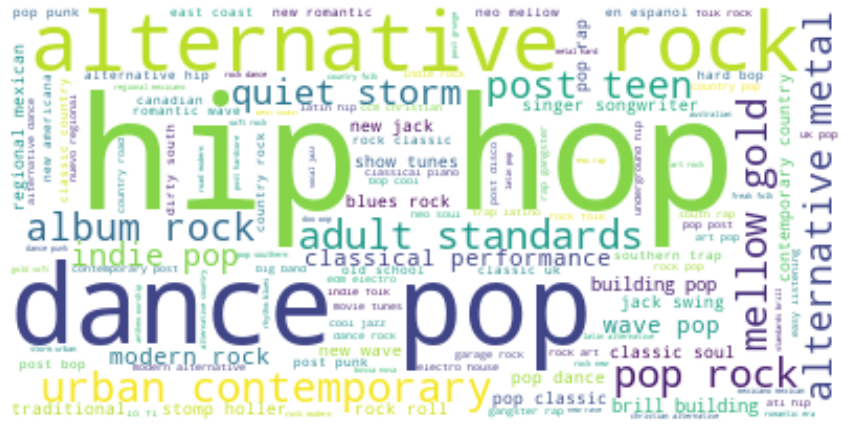

In [13]:
words = ' '.join(genres_df['genres_clean'])

wordcloud = WordCloud(background_color="white").generate(words)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Okay I'm getting a sense for what terms pop up most, but let's formalize it by getting a list of the most frequent terms.

In [14]:
from collections import Counter

# split() returns list of all the words in the string 
split_it = words.split() 

# Pass the split_it list to instance of Counter class. 
counter = Counter(split_it)

# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = counter.most_common(20) 
  
print(most_occur) 

[('pop', 4957), ('rock', 3921), ('rap', 1639), ('alternative', 1617), ('hip', 1615), ('indie', 1545), ('hop', 1496), ('classic', 1462), ('dance', 1178), ('folk', 1171), ('new', 1169), ('jazz', 1155), ('classical', 1147), ('country', 1071), ('soul', 1052), ('modern', 1017), ('contemporary', 968), ('trap', 866), ('latin', 776), ('blues', 681)]


<BarContainer object of 20 artists>

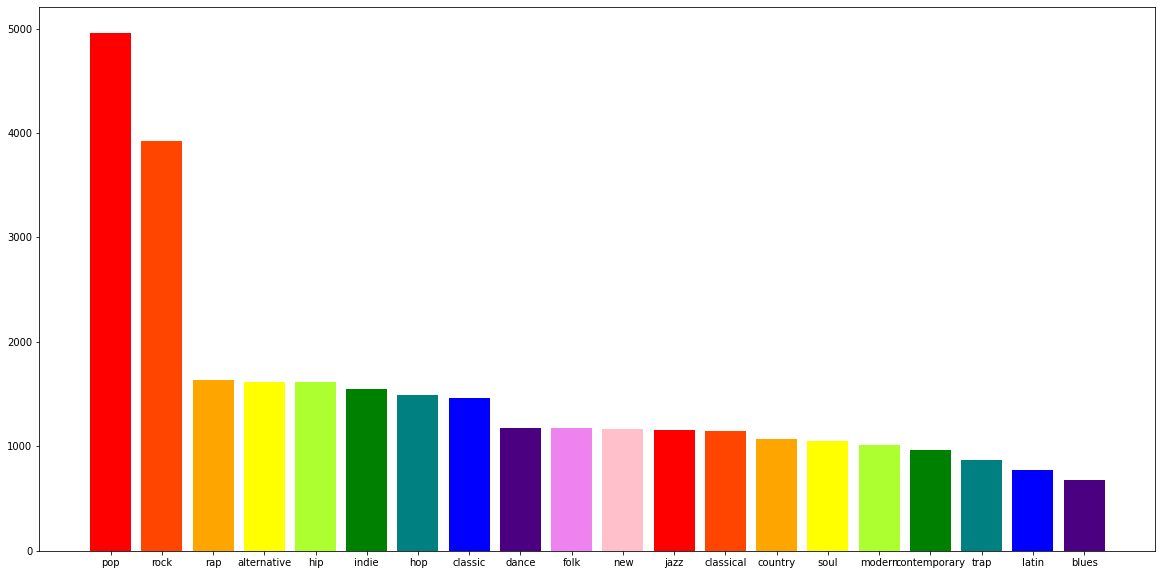

In [15]:
most_occur_df = pd.DataFrame(most_occur)

rainbow=['r','orangered','orange','yellow','greenyellow','g','teal','b','indigo','violet', 'pink']

plt.figure(figsize=(20,10))
plt.bar(most_occur_df[0], most_occur_df[1], color=rainbow)

That worked nicely. I'm going to combine hip and hop to be hip hop then later change the column name to hiphop so I don't have spaces in my column names. I'm also going to drop "new" as that's 

In [16]:
# Putting 'hip hop' together and also adding a space after 'classic' so it's not confused with classical.
genre_list = ['pop','rock','rap','alternative','hip hop','indie','classic ','dance','folk','new','jazz','classical', 'country', 'soul','modern','contemporary','trap','latin','blues']

genre_contains_df = pd.DataFrame()

for genre in genre_list:
  genre_contains_df[genre] = genres_df['genres_clean'].str.contains(genre)
  genre_contains_df[genre] = genre_contains_df[genre].astype(np.int8)

I'm curious if any of these genres columns are highly correlated. I will check. It might be good to rename "hip hop" and "classic " to "hiphop" and "classic" but I don't want that to mess up my analysis, so I will do that at the end of my genre analysis, ***don't forget***!

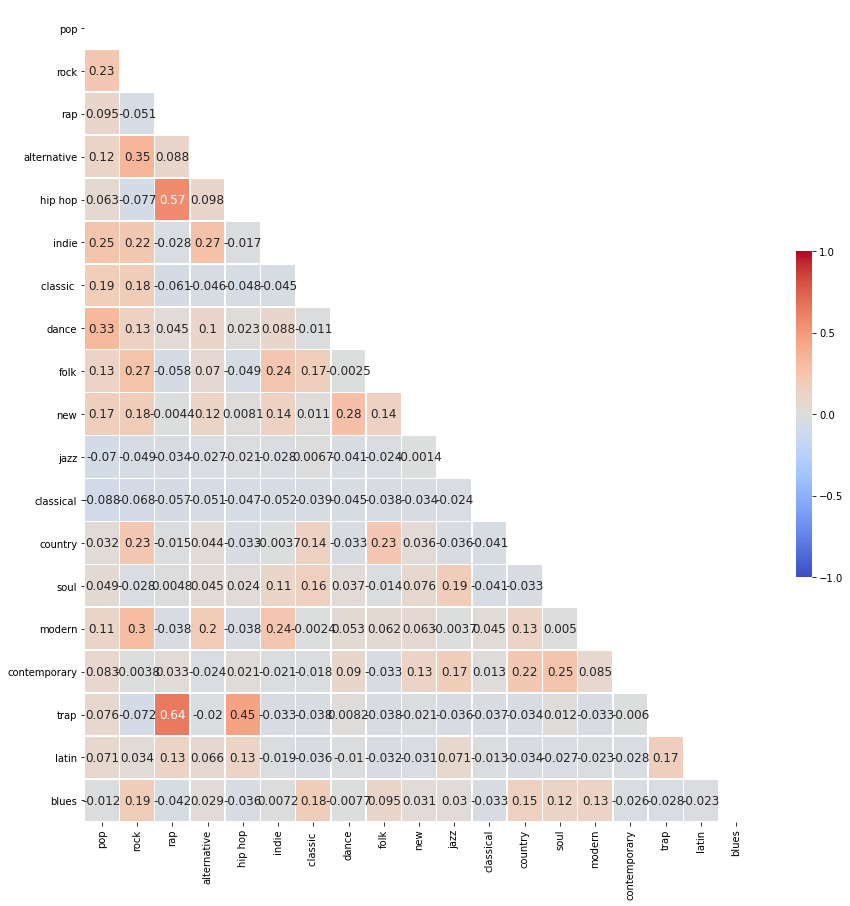

In [17]:
corr_matrix = genre_contains_df.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f, ax = plt.subplots(figsize=(15,15))

heatmap = sns.heatmap(corr_matrix,
                      mask=mask,
                      linewidths=.5,
                      cmap='coolwarm',
                      cbar_kws = {'shrink': .4,
                                  'ticks': [-1,-.5,0,.5,1]},
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size':12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [18]:
def FeatureCorrelationDict(df, correlation_threshold):
  '''This function creates a dictionary of dictionaries!
  Each column has a dictionary of other columns that are over the 
  correlation threshold (absolute value) together with the correlation.'''
  correlation_threshold = correlation_threshold
  corr_features_dict = {}
  for i in range(df.shape[1]):
    feature_dict = {}
    for j in range(df.shape[1]):
      if j!=i:
        score = df[df.columns[i]].corr(df[df.columns[j]])
        if abs(score) > correlation_threshold:
          feature_dict[df.columns[j]]=round(score,2)
    corr_features_dict[df.columns[i]]=feature_dict
  return corr_features_dict

feature_corr = FeatureCorrelationDict(genre_contains_df, .4)
feature_corr

{'alternative': {},
 'blues': {},
 'classic ': {},
 'classical': {},
 'contemporary': {},
 'country': {},
 'dance': {},
 'folk': {},
 'hip hop': {'rap': 0.57, 'trap': 0.45},
 'indie': {},
 'jazz': {},
 'latin': {},
 'modern': {},
 'new': {},
 'pop': {},
 'rap': {'hip hop': 0.57, 'trap': 0.64},
 'rock': {},
 'soul': {},
 'trap': {'hip hop': 0.45, 'rap': 0.64}}

So the only genres that are correlated over .4 are rap, hip hop, and trap. Interesting.

Now I am interested in seeing the overlap of genres. To start, I will create a column that adds up the contents of the genre columns.

In [19]:
# Creating a genre sum column
genre_contains_df['genre_sum'] = genre_contains_df.iloc[:,:].sum(axis=1)
genre_contains_df.head(20)

pop  rock  rap  alternative  ...  trap  latin  blues  genre_sum
0     0     0    0            0  ...     0      0      0          0
1     0     0    0            0  ...     0      0      0          0
2     0     0    0            0  ...     0      0      0          0
3     0     0    0            0  ...     0      0      0          0
4     0     0    0            0  ...     0      0      0          0
5     0     0    0            0  ...     0      0      0          0
6     0     0    0            0  ...     0      0      0          0
7     0     0    0            0  ...     0      0      0          0
8     0     1    0            0  ...     0      0      0          1
9     0     0    1            0  ...     1      0      0          3
10    0     0    1            0  ...     1      0      0          2
11    0     0    0            0  ...     0      0      0          0
12    0     0    1            0  ...     1      0      0          3
13    0     0    1            0  ...     1      0      0          4
14    0     0    0            0  ...     0      0      0          0
15    0     0    0            0  ...     0      0      0          0
16    0     0    0            0  ...     0      0      0          0
17    1     1    0            0  ...     0      0      0          4
18    0     0    0            0  ...     0      0      0          3
19    0     0    0            0  ...     0      0      0          0

[20 rows x 20 columns]

In [20]:
# Calculating the Percent of 
genres_sum_percent = genre_contains_df['genre_sum'].value_counts() / genre_contains_df.shape[0]
genres_sum_percent_df = pd.DataFrame(genres_sum_percent)
genres_sum_percent_df

genre_sum
0   0.518968
1   0.183891
2   0.134763
3   0.084589
4   0.048257
5   0.019840
6   0.007043
7   0.002092
8   0.000558

Text(0, 0.5, 'Percentage of Data')

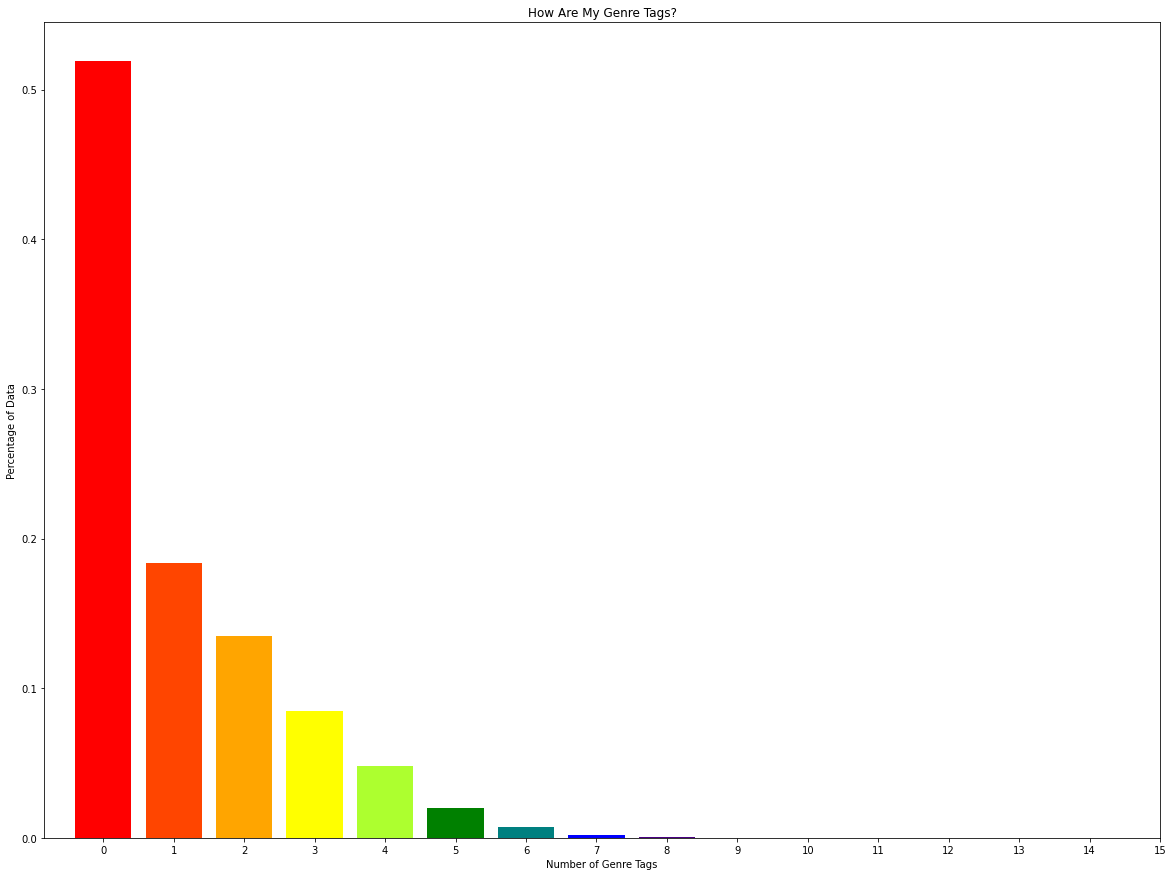

In [21]:
# Creating a plot of the percentage by number of genre tags
labels = genres_sum_percent_df['genre_sum']

plt.figure(figsize=(20,15))
plt.bar(genres_sum_percent_df.index, labels, color=rainbow)
plt.title('How Are My Genre Tags?')
plt.xlabel('Number of Genre Tags')
plt.xticks(ticks = np.arange(0,16))
plt.ylabel('Percentage of Data')

This shows that even with all of those genre tags, over half of the songs are do not have any genre tag. I wonder what those artists' genres look like.

#### **Adding More Genre Tags**

In [22]:
zero_genre_index = genre_contains_df[(genre_contains_df['genre_sum']==0)].index
zero_genre_df = genres_df.iloc[zero_genre_index,:]
print(zero_genre_df['genres_clean'].value_counts())

                                           9857
movie tunes                                  69
show tunes                                   63
hollywood                                    56
orchestral performance                       50
                                           ... 
italian bass opera                            1
hi-nrg italian disco post-disco               1
shabad                                        1
japanese instrumental otacore scorecore       1
metalcore north carolina emo screamo          1
Name: genres_clean, Length: 1876, dtype: int64


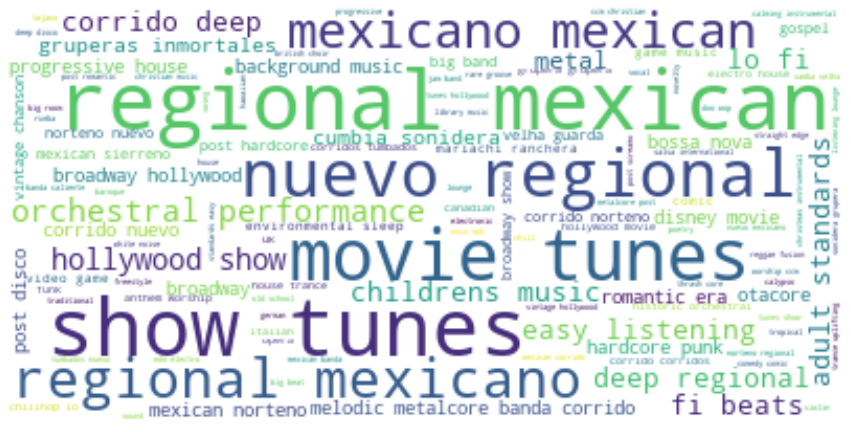

In [23]:
words = ' '.join(zero_genre_df['genres_clean'])

wordcloud = WordCloud(background_color="white").generate(words)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[('tunes', 334), ('regional', 315), ('mexican', 301), ('music', 245), ('corrido', 219), ('deep', 217), ('show', 209), ('hollywood', 203), ('house', 183), ('nuevo', 155), ('mexicano', 155), ('movie', 149), ('broadway', 134), ('vintage', 131), ('progressive', 122), ('italian', 120), ('norteno', 120), ('orchestra', 114), ('punk', 110), ('banda', 108)]


<BarContainer object of 20 artists>

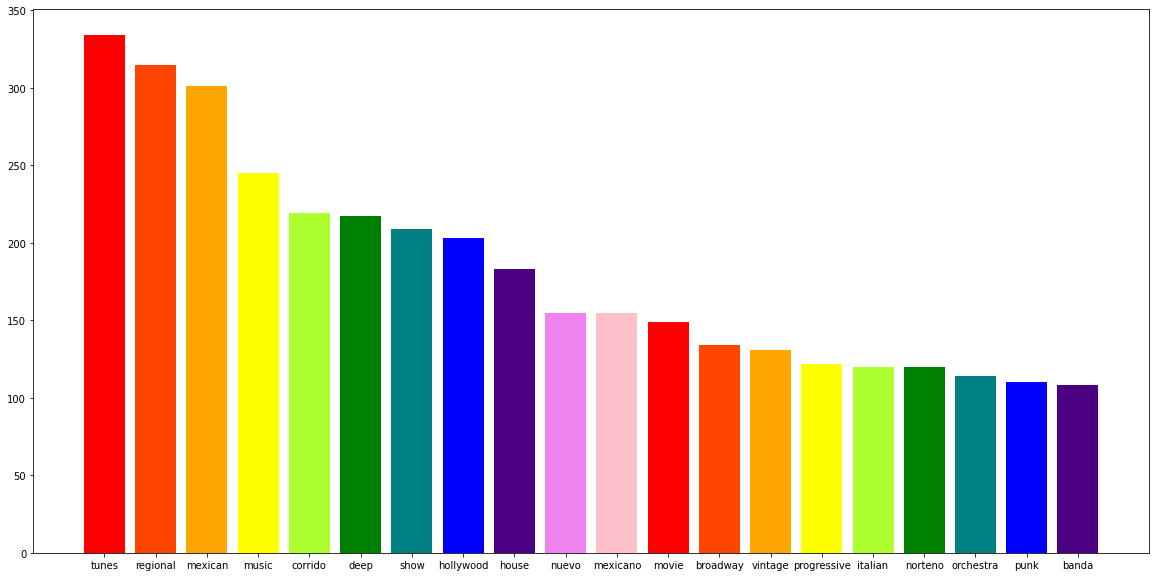

In [24]:
# split() returns list of all the words in the string 
split_it = words.split() 

# Pass the split_it list to instance of Counter class. 
counter = Counter(split_it)

# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = counter.most_common(20) 
  
print(most_occur)

most_occur_df = pd.DataFrame(most_occur)

plt.figure(figsize=(20,10))
plt.bar(most_occur_df[0], most_occur_df[1], color=rainbow)

Okay I am going to try adding these, but I will keep the separate data frames. Maybe I could compare them later.

In [25]:
# I'm guessing tunes normally goes with show tunes and movie tunes and probably broadway tunes as well.
# I'm thinking all of the different terms relating to Mexican music are connected as well.

genre_list_2 = ['tunes', 'regional','mexican','corrido','deep','show','hollywood','house','nuevo','mexicano','movie','broadway', 'vintage', 'progressive','italian','norteno','orchestra','punk','banda']

genre_contains_2_df = pd.DataFrame()

for genre in genre_list_2:
  genre_contains_2_df[genre] = genres_df['genres_clean'].str.contains(genre)
  genre_contains_2_df[genre] = genre_contains_2_df[genre].astype(np.int8)
  
genre_contains_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   tunes        28680 non-null  int8 
 1   regional     28680 non-null  int8 
 2   mexican      28680 non-null  int8 
 3   corrido      28680 non-null  int8 
 4   deep         28680 non-null  int8 
 5   show         28680 non-null  int8 
 6   hollywood    28680 non-null  int8 
 7   house        28680 non-null  int8 
 8   nuevo        28680 non-null  int8 
 9   mexicano     28680 non-null  int8 
 10  movie        28680 non-null  int8 
 11  broadway     28680 non-null  int8 
 12  vintage      28680 non-null  int8 
 13  progressive  28680 non-null  int8 
 14  italian      28680 non-null  int8 
 15  norteno      28680 non-null  int8 
 16  orchestra    28680 non-null  int8 
 17  punk         28680 non-null  int8 
 18  banda        28680 non-null  int8 
dtypes: int8(19)
memory usage: 532.3 KB


In [26]:
genre_contains_all_df = pd.DataFrame()

# Going to drop the old genre_sum column and create a new one after.
genre_contains_all_df = pd.concat([genre_contains_df.drop(columns=['genre_sum'],axis=1), genre_contains_2_df], axis=1)

# Let's see all those genre tag columns!
genre_contains_all_df.columns

Index(['pop', 'rock', 'rap', 'alternative', 'hip hop', 'indie', 'classic ',
       'dance', 'folk', 'new', 'jazz', 'classical', 'country', 'soul',
       'modern', 'contemporary', 'trap', 'latin', 'blues', 'tunes', 'regional',
       'mexican', 'corrido', 'deep', 'show', 'hollywood', 'house', 'nuevo',
       'mexicano', 'movie', 'broadway', 'vintage', 'progressive', 'italian',
       'norteno', 'orchestra', 'punk', 'banda'],
      dtype='object')

In [27]:
# Creating an updated genre sum column
genre_contains_all_df['genre_sum'] = genre_contains_all_df.iloc[:,:].sum(axis=1)

# Calculating the Percent of 
genres_sum_percent = genre_contains_all_df['genre_sum'].value_counts() / genre_contains_all_df.shape[0]
genres_sum_percent_df = pd.DataFrame(genres_sum_percent)
genres_sum_percent_df

genre_sum
0    0.458543
1    0.185391
2    0.151499
3    0.100314
4    0.059310
5    0.027720
6    0.011506
7    0.003696
8    0.001499
9    0.000453
10   0.000070

Text(0, 0.5, 'Percentage of Data')

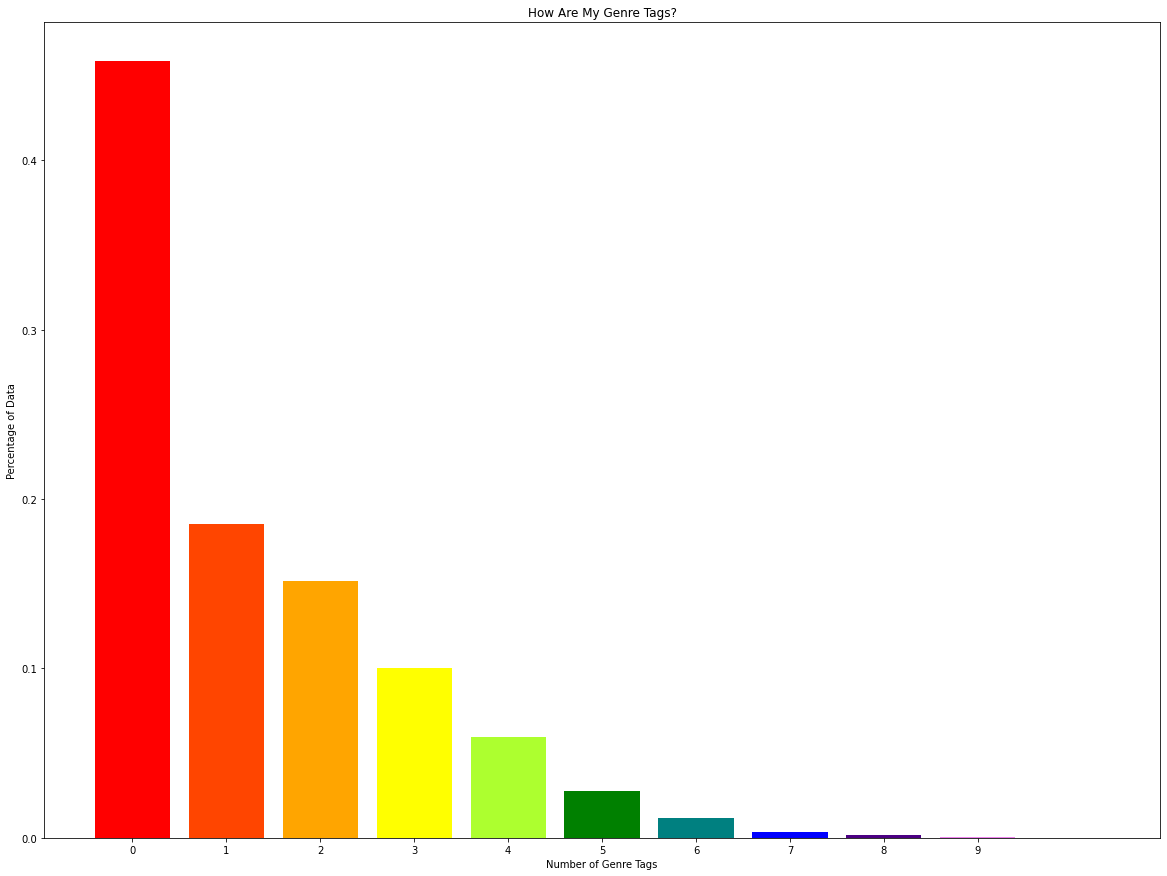

In [28]:
# Creating a plot of the percentage by number of genre tags
labels = genres_sum_percent_df['genre_sum']

plt.figure(figsize=(20,15))
plt.bar(genres_sum_percent_df.index, labels, color=rainbow)
plt.title('How Are My Genre Tags?')
plt.xlabel('Number of Genre Tags')
plt.xticks(ticks = np.arange(0,10))
plt.ylabel('Percentage of Data')

There are still a lot of artists that have 0 genre tags. Wonder how many of those were just blank to begin with.

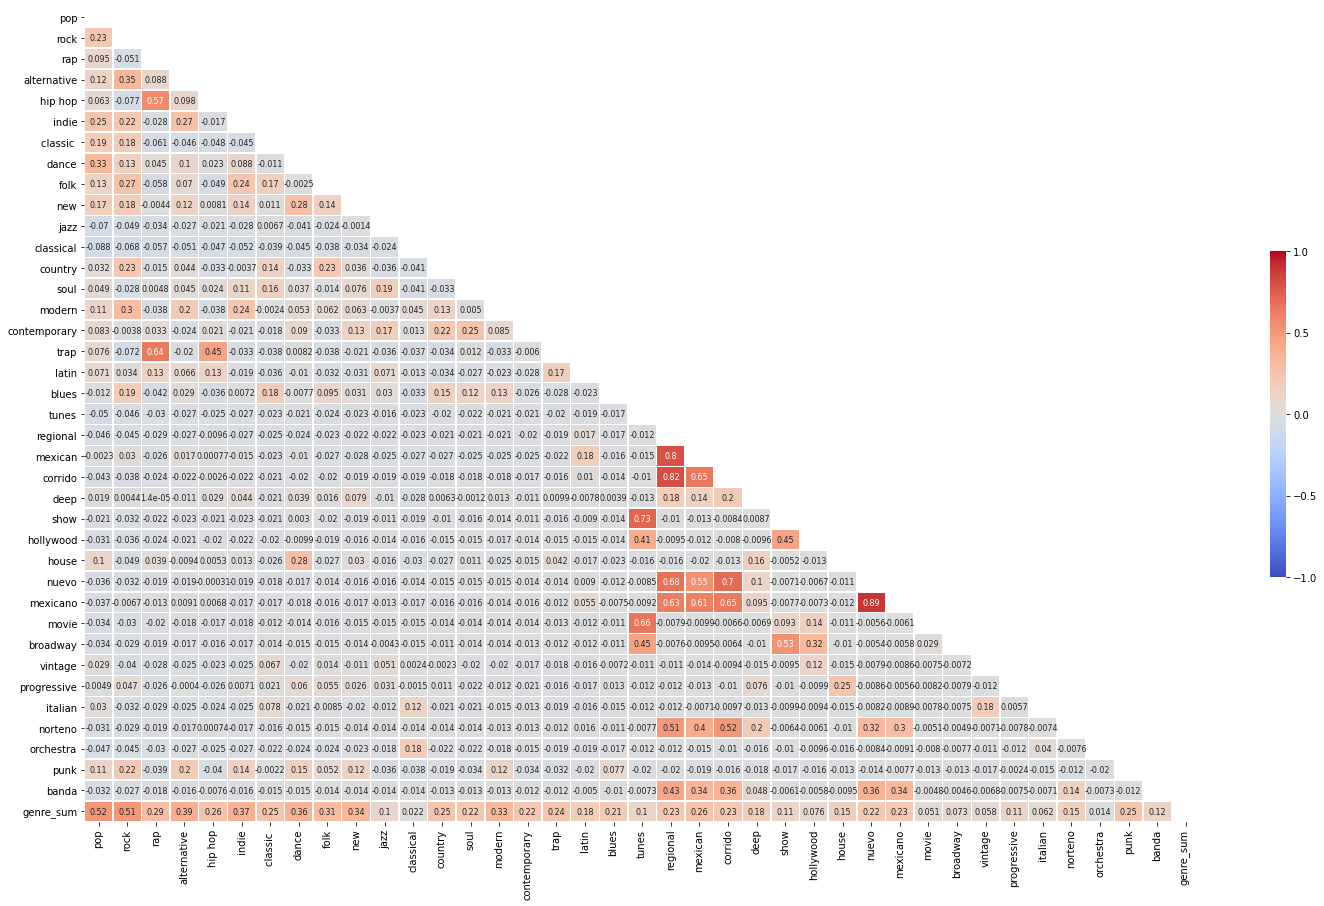

In [29]:
corr_matrix = genre_contains_all_df.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f, ax = plt.subplots(figsize=(25,15))

heatmap = sns.heatmap(corr_matrix,
                      mask=mask,
                      linewidths=.5,
                      cmap='coolwarm',
                      cbar_kws = {'shrink': .4,
                                  'ticks': [-1,-.5,0,.5,1]},
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size':8})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

As expected, there's correlation between regional, mexican, corrido, nuevo, and mexicana.

There's also expected correlation between show, broadway, tunes, and hollywood.

In [30]:
feature_corr = FeatureCorrelationDict(genre_contains_all_df, .4)
pd.DataFrame(feature_corr).dropna(axis=1,how='all').replace(np.nan, '')

pop  rock   rap hip hop  ... broadway norteno banda genre_sum
genre_sum  0.52  0.51                ...                                 
hip hop                0.57          ...                                 
trap                   0.64    0.45  ...                                 
rap                            0.57  ...                                 
show                                 ...     0.53                        
hollywood                            ...                                 
movie                                ...                                 
broadway                             ...                                 
mexican                              ...              0.4                
corrido                              ...             0.52                
nuevo                                ...                                 
mexicano                             ...                                 
norteno                              ...                                 
banda                                ...                                 
regional                             ...             0.51  0.43          
tunes                                ...     0.45                        
pop                                  ...                             0.52
rock                                 ...                             0.51

[18 rows x 18 columns]

#### **Breaking Down Movie and Show Tunes Tags**

In [31]:
def TagsOverlap(genre_list):
  '''Creating a function to observe the overlap of tags.
  What percentage of entries with [column] tag also have [row] tag?'''
  overlap_dict = {}
  for genre1 in genre_list:
    genre_dict = {}
    genre_index = genre_contains_all_df[(genre_contains_all_df[genre1]==1)].index
    fxn_genre_df = genres_df.iloc[genre_index,:]
    inside_dict={}
    for genre2 in genre_list:
      genre1_genre2 = fxn_genre_df['genres_clean'].str.contains(genre2).sum()
      overlap = genre1_genre2 / fxn_genre_df.shape[0]
      inside_dict[genre2] = overlap
    overlap_dict[genre1] = inside_dict
  return pd.DataFrame(overlap_dict)

In [32]:
genre_list=['hollywood','broadway','show','movie','tunes']
TagsOverlap(genre_list)

hollywood  broadway      show     movie     tunes
hollywood   1.000000  0.400000  0.427984  0.177632  0.326590
broadway    0.256881  1.000000  0.407407  0.032895  0.289017
show        0.477064  0.707143  1.000000  0.125000  0.615607
movie       0.123853  0.035714  0.078189  1.000000  0.439306
tunes       0.518349  0.714286  0.876543  1.000000  1.000000

From this I think it's safe to drop **tunes** as it seems to almost always go with **show** or **movie**.

#### **Breaking Down Rap, Trap, and Hip Hop Tags**

In [33]:
genre_list=['rap','trap','hip hop']
TagsOverlap(genre_list)

rap      trap   hip hop
rap      1.000000  1.000000  0.709078
trap     0.429916  1.000000  0.370264
hip hop  0.491332  0.596774  1.000000

Trap is clearly a subgenre of rap, but sometimes you have hip hop without rap. I say leave them all for now.

#### **Breaking Down the Regional Mexican Genre Tags**

It's hard to tell which tags are the best to keep and which should be dropped, because of my limited domain knowledge in these genres. With a little bit of research it seems like we have several sub genres of **Regional Mexican** music.

* **Corrido** is typically lyrical ballads that tell stories of hardship.

* **Norteno** refers to a genre of music from Northern Mexico where native Mexican music mixed with polka and other Eastern European genres. 

* **Banda** seems to be another genre of Regional Mexican music that includes wind instruments.

I don't know if fans of Regional Mexican music that listen to Corrido would enjoy Norteno or Banda, so I'm not so sure I should clump them all together. It seems like I could drop Regional Mexican music and cover it with the sub genres.

I could also probably do this analysis with rock music and parse out classic rock versus indie rock, but they don't have as strong of a correlation, which is why I'm not doing that analysis.

In [34]:
genre_list = ['corrido','norteno','banda','nuevo','mexicano','regional','mexican']
df = TagsOverlap(genre_list)
df

corrido   norteno  banda     nuevo  mexicano  regional   mexican
corrido   1.000000  0.678832  0.496  0.832335  0.709184  0.686567  0.442308
norteno   0.395745  1.000000  0.152  0.293413  0.250000  0.325373  0.209615
banda     0.263830  0.138686  1.000  0.317365  0.270408  0.265672  0.171154
nuevo     0.591489  0.357664  0.424  1.000000  0.826531  0.480597  0.311538
mexicano  0.591489  0.357664  0.424  0.970060  1.000000  0.480597  0.376923
regional  0.978723  0.795620  0.712  0.964072  0.821429  1.000000  0.644231
mexican   0.978723  0.795620  0.712  0.970060  1.000000  1.000000  1.000000

You read this table as, "The percent of entries with [column name] that also have [row name] is ____." 

* You can see that almost all artists tagged with **corrido** have **Regional Mexican** in their genre description, but there's not the same overlap with **norteno** and **banda**. Looks like I'm onto something.

* I do not need all of my genre tags to be completely linearly independent, but if everytime something has one tag, it has the other tag, that seems redundant. Looks like having both **regional** and **mexican** is definitely redundant, same with **nuevo** and **mexicano**, same with **mexican** and **mexicano**, so I'm going to drop **regional**, **nuevo**, and **mexicano** and see what it looks like.

In [35]:
genre_list = ['corrido','norteno','banda','mexican']
mexican_df = TagsOverlap(genre_list)
mexican_df

corrido   norteno  banda   mexican
corrido  1.000000  0.678832  0.496  0.442308
norteno  0.395745  1.000000  0.152  0.209615
banda    0.263830  0.138686  1.000  0.171154
mexican  0.978723  0.795620  0.712  1.000000

In [36]:
print(f'Percent of songs with mexican tag that have corrido, norteno, and banda combined = {mexican_df.iloc[0:3,-1].sum(axis=0)}')

Percent of songs with mexican tag that have corrido, norteno, and banda combined = 0.823076923076923


There are almost 18% of songs that have the "Mexican" tag in their genre that don't have corrido, norteno, or banda. I think that makes it worth keeping. I will now drop **regional, nuevo,** and **mexicano** from the all genre dataframe.

#### **Dropping Some Tags and Fixing Some Column Names**

* tunes, regional, nuevo, and mexicano

In [37]:
genre_contains_all_df.drop(columns=['tunes','regional','nuevo','mexicano', 'genre_sum'], axis=1, inplace=True)
genre_contains_all_df.columns

Index(['pop', 'rock', 'rap', 'alternative', 'hip hop', 'indie', 'classic ',
       'dance', 'folk', 'new', 'jazz', 'classical', 'country', 'soul',
       'modern', 'contemporary', 'trap', 'latin', 'blues', 'mexican',
       'corrido', 'deep', 'show', 'hollywood', 'house', 'movie', 'broadway',
       'vintage', 'progressive', 'italian', 'norteno', 'orchestra', 'punk',
       'banda'],
      dtype='object')

Okay one last time let's analyze what artists still have no genre tags, I am particularly looking for any of the terms I dropped.

In [38]:
# Creating an updated genre sum column
genre_contains_all_df['genre_sum'] = genre_contains_all_df.iloc[:,:-1].sum(axis=1)

# Calculating the Percent of 
genres_sum_percent = genre_contains_all_df['genre_sum'].value_counts() / genre_contains_all_df.shape[0]
genres_sum_percent_df = pd.DataFrame(genres_sum_percent)
genres_sum_percent_df

genre_sum
0    0.459798
1    0.193480
2    0.150558
3    0.101953
4    0.055893
5    0.024372
6    0.009379
7    0.002964
8    0.001290
9    0.000279
10   0.000035

I increased the number of songs with 1 genre tag by 1 percent, that means removing some of those redundant tags had a measurable result.

In [39]:
zero_genre_index = genre_contains_all_df[(genre_contains_all_df['genre_sum']==0)].index
zero_genre_df = genres_df.iloc[zero_genre_index,:]
print(zero_genre_df['genres_clean'].value_counts())

                                              9857
sleep                                           42
gospel                                          41
rebetiko                                        34
cumbia sonidera                                 33
                                              ... 
small room                                       1
canadian metal christian melodic metalcore       1
reggae fusion roots                              1
bebop big band stride swing                      1
flamenco rumba world                             1
Name: genres_clean, Length: 1292, dtype: int64


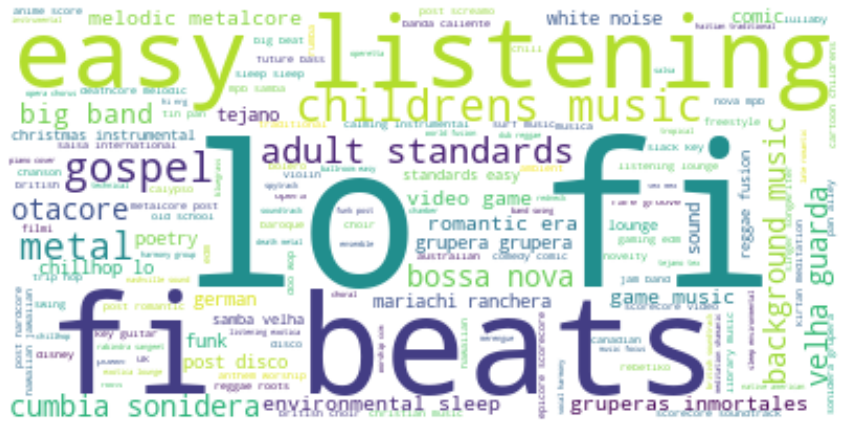

In [40]:
words = ' '.join(zero_genre_df['genres_clean'])

wordcloud = WordCloud(background_color="white").generate(words)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[('music', 226), ('gospel', 96), ('sleep', 87), ('cumbia', 84), ('soundtrack', 75), ('metal', 72), ('lo-fi', 70), ('beats', 70), ('childrens', 70), ('instrumental', 68), ('easy', 64), ('listening', 64), ('funk', 64), ('band', 64), ('environmental', 63), ('sound', 57), ('big', 57), ('reggae', 57), ('lounge', 56), ('scorecore', 53)]


<BarContainer object of 20 artists>

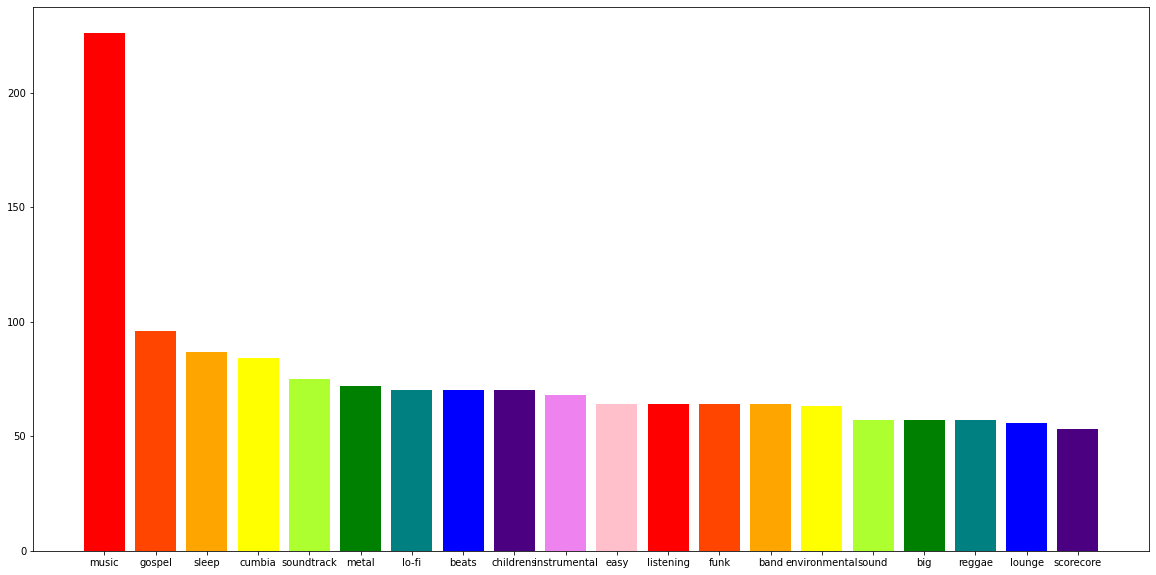

In [41]:
# split() returns list of all the words in the string 
split_it = words.split() 

# Pass the split_it list to instance of Counter class. 
counter = Counter(split_it)

# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = counter.most_common(20) 
  
print(most_occur)

most_occur_df = pd.DataFrame(most_occur)

plt.figure(figsize=(20,10))
plt.bar(most_occur_df[0], most_occur_df[1], color=rainbow)

Okay I feel pretty good about this, this is always something I can revisit, but I think I already have a lot of genre tags. 

* Now I will fix the 'hip hop' and 'classic ' column names to get rid of spaces for formatting. 
* I will drop the genre_sum column as I don't need that for analysis anymore.
* I will also create a version of this where I drop the rows that have a genre_sum of zero for my supervised learning.

In [42]:
genre_contains_all_df.rename(columns={'hip hop': 'hiphop', 'classic ': 'classic'}, inplace=True)
genre_contains_all_df.drop(columns=['genre_sum'], inplace=True)
print(genre_contains_all_df.columns)
print(f'This DF has {genre_contains_all_df.shape[0]} rows.')

Index(['pop', 'rock', 'rap', 'alternative', 'hiphop', 'indie', 'classic',
       'dance', 'folk', 'new', 'jazz', 'classical', 'country', 'soul',
       'modern', 'contemporary', 'trap', 'latin', 'blues', 'mexican',
       'corrido', 'deep', 'show', 'hollywood', 'house', 'movie', 'broadway',
       'vintage', 'progressive', 'italian', 'norteno', 'orchestra', 'punk',
       'banda'],
      dtype='object')
This DF has 28680 rows.


In [43]:
genres_tags_nozero_df = pd.DataFrame()
genres_nozero_df = pd.DataFrame()

genres_tags_nozero_df = genre_contains_all_df.drop(index=zero_genre_index)
genres_nozero_df = genres_df.drop(index=zero_genre_index)


In [44]:
difference = genre_contains_all_df.shape[0]-genres_tags_nozero_df.shape[0]

print(f'This DF has {genres_tags_nozero_df.shape[0]} rows.')
print(f'I lost {difference} rows.')
print(f'I lost {difference - 9857} artists with non-blank genres')

print('')
print('***********************************************')
print('')

print(genres_tags_nozero_df.info())
print('')
print('***********************************************')
print('')
print(genres_nozero_df.info())

This DF has 15493 rows.
I lost 13187 rows.
I lost 3330 artists with non-blank genres

***********************************************

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15493 entries, 0 to 28679
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   pop           15493 non-null  int8 
 1   rock          15493 non-null  int8 
 2   rap           15493 non-null  int8 
 3   alternative   15493 non-null  int8 
 4   hiphop        15493 non-null  int8 
 5   indie         15493 non-null  int8 
 6   classic       15493 non-null  int8 
 7   dance         15493 non-null  int8 
 8   folk          15493 non-null  int8 
 9   new           15493 non-null  int8 
 10  jazz          15493 non-null  int8 
 11  classical     15493 non-null  int8 
 12  country       15493 non-null  int8 
 13  soul          15493 non-null  int8 
 14  modern        15493 non-null  int8 
 15  contemporary  15493 non-null  int8 
 16  trap         

It's a bummer to lose almost half of my data. I have to remember that 9,857 of those rows had no genre listed. Only lost 3,330 artists with genre tags. Could be worse.

### **Artist**

In [45]:
genres_df['artists'][:20]

0                      "Cats" 1981 Original London Cast
1                             "Cats" 1983 Broadway Cast
2           "Fiddler On The Roof” Motion Picture Chorus
3        "Fiddler On The Roof” Motion Picture Orchestra
4     "Joseph And The Amazing Technicolor Dreamcoat"...
5     "Joseph And The Amazing Technicolor Dreamcoat"...
6                                "Mama" Helen Teagarden
7                               "Test for Victor Young"
8                                   "Weird Al" Yankovic
9                                                  $NOT
10                                          $atori Zoom
11                                                $pyda
12                                         $tupid Young
13                                          $uicideBoy$
14           'In The Heights' Original Broadway Company
15                            'Legally Blonde' Ensemble
16                        'Legally Blonde' Greek Chorus
17                                         'Til 

In [46]:
genres_df['artists'].value_counts()

Roman Tam            1
Snehal Bhatkar       1
Carl Cotner          1
Arty Skye            1
Buddy Miles          1
                    ..
Lacy J. Dalton       1
Sky Rompiendo        1
The White Stripes    1
Hepzibah Menuhin     1
Lenny Welch          1
Name: artists, Length: 28680, dtype: int64

These look to be formatted okay and there's not much for me to do with them now. I have not thought of a way to use them for features. Let's look into the numeric features.

## Numeric Columns

In [47]:
num_cols_df = genres_nozero_df.select_dtypes(exclude=object)
print(num_cols_df.head())
num_cols_df.describe()

    acousticness  danceability    duration_ms  ...  key  mode  count
0       0.590111      0.467222  250318.555556  ...    5     1      9
8       0.173145      0.662787  218948.196721  ...    9     1    122
9       0.544467      0.789800  137910.466667  ...    1     1     15
10      0.239000      0.883000  141519.000000  ...    6     1      2
12      0.148100      0.854000  190572.000000  ...    1     1      2

[5 rows x 14 columns]


acousticness  danceability  ...          mode         count
count  15493.000000  15493.000000  ...  15493.000000  15493.000000
mean       0.394194      0.565338  ...      0.767056     19.891822
std        0.335967      0.164786  ...      0.422720     63.678455
min        0.000002      0.061800  ...      0.000000      1.000000
25%        0.087767      0.459167  ...      1.000000      2.000000
50%        0.298500      0.572500  ...      1.000000      4.000000
75%        0.696167      0.684000  ...      1.000000     14.000000
max        0.996000      0.986000  ...      1.000000   3169.000000

[8 rows x 14 columns]

In [48]:
# Fixing the index
num_cols_df.index = np.arange(0,15493)
num_cols_df.head()

acousticness  danceability    duration_ms  ...  key  mode  count
0      0.590111      0.467222  250318.555556  ...    5     1      9
1      0.173145      0.662787  218948.196721  ...    9     1    122
2      0.544467      0.789800  137910.466667  ...    1     1     15
3      0.239000      0.883000  141519.000000  ...    6     1      2
4      0.148100      0.854000  190572.000000  ...    1     1      2

[5 rows x 14 columns]

* There are several columns on a 0 to 1 scale including: **acousticness, danceability, energy, instrumentalness, liveness, speechiness, valence, mode (binary).**

* Duration here is in milliseconds. Makes sense as the easiest way to quantize and represent time as one number.

* Loudness is  measured in LUFS which is Loudness Unit Full Scale. It goes from -60 to 1.342.

* Tempo is measured in BPM and goes from 0 to 217.743 -- I wonder what song has 0 BPM?

* Popularity goes from 0 to 93. I'm curious what artists are at 93.

* Key goes from 0 to 11 and corresponds to musical pitches. It goes up by half notes.

* Mode is binary, major or minor. 1 is major, 0 is minor.

* Count is the number of tracks by that artist on Spotify.

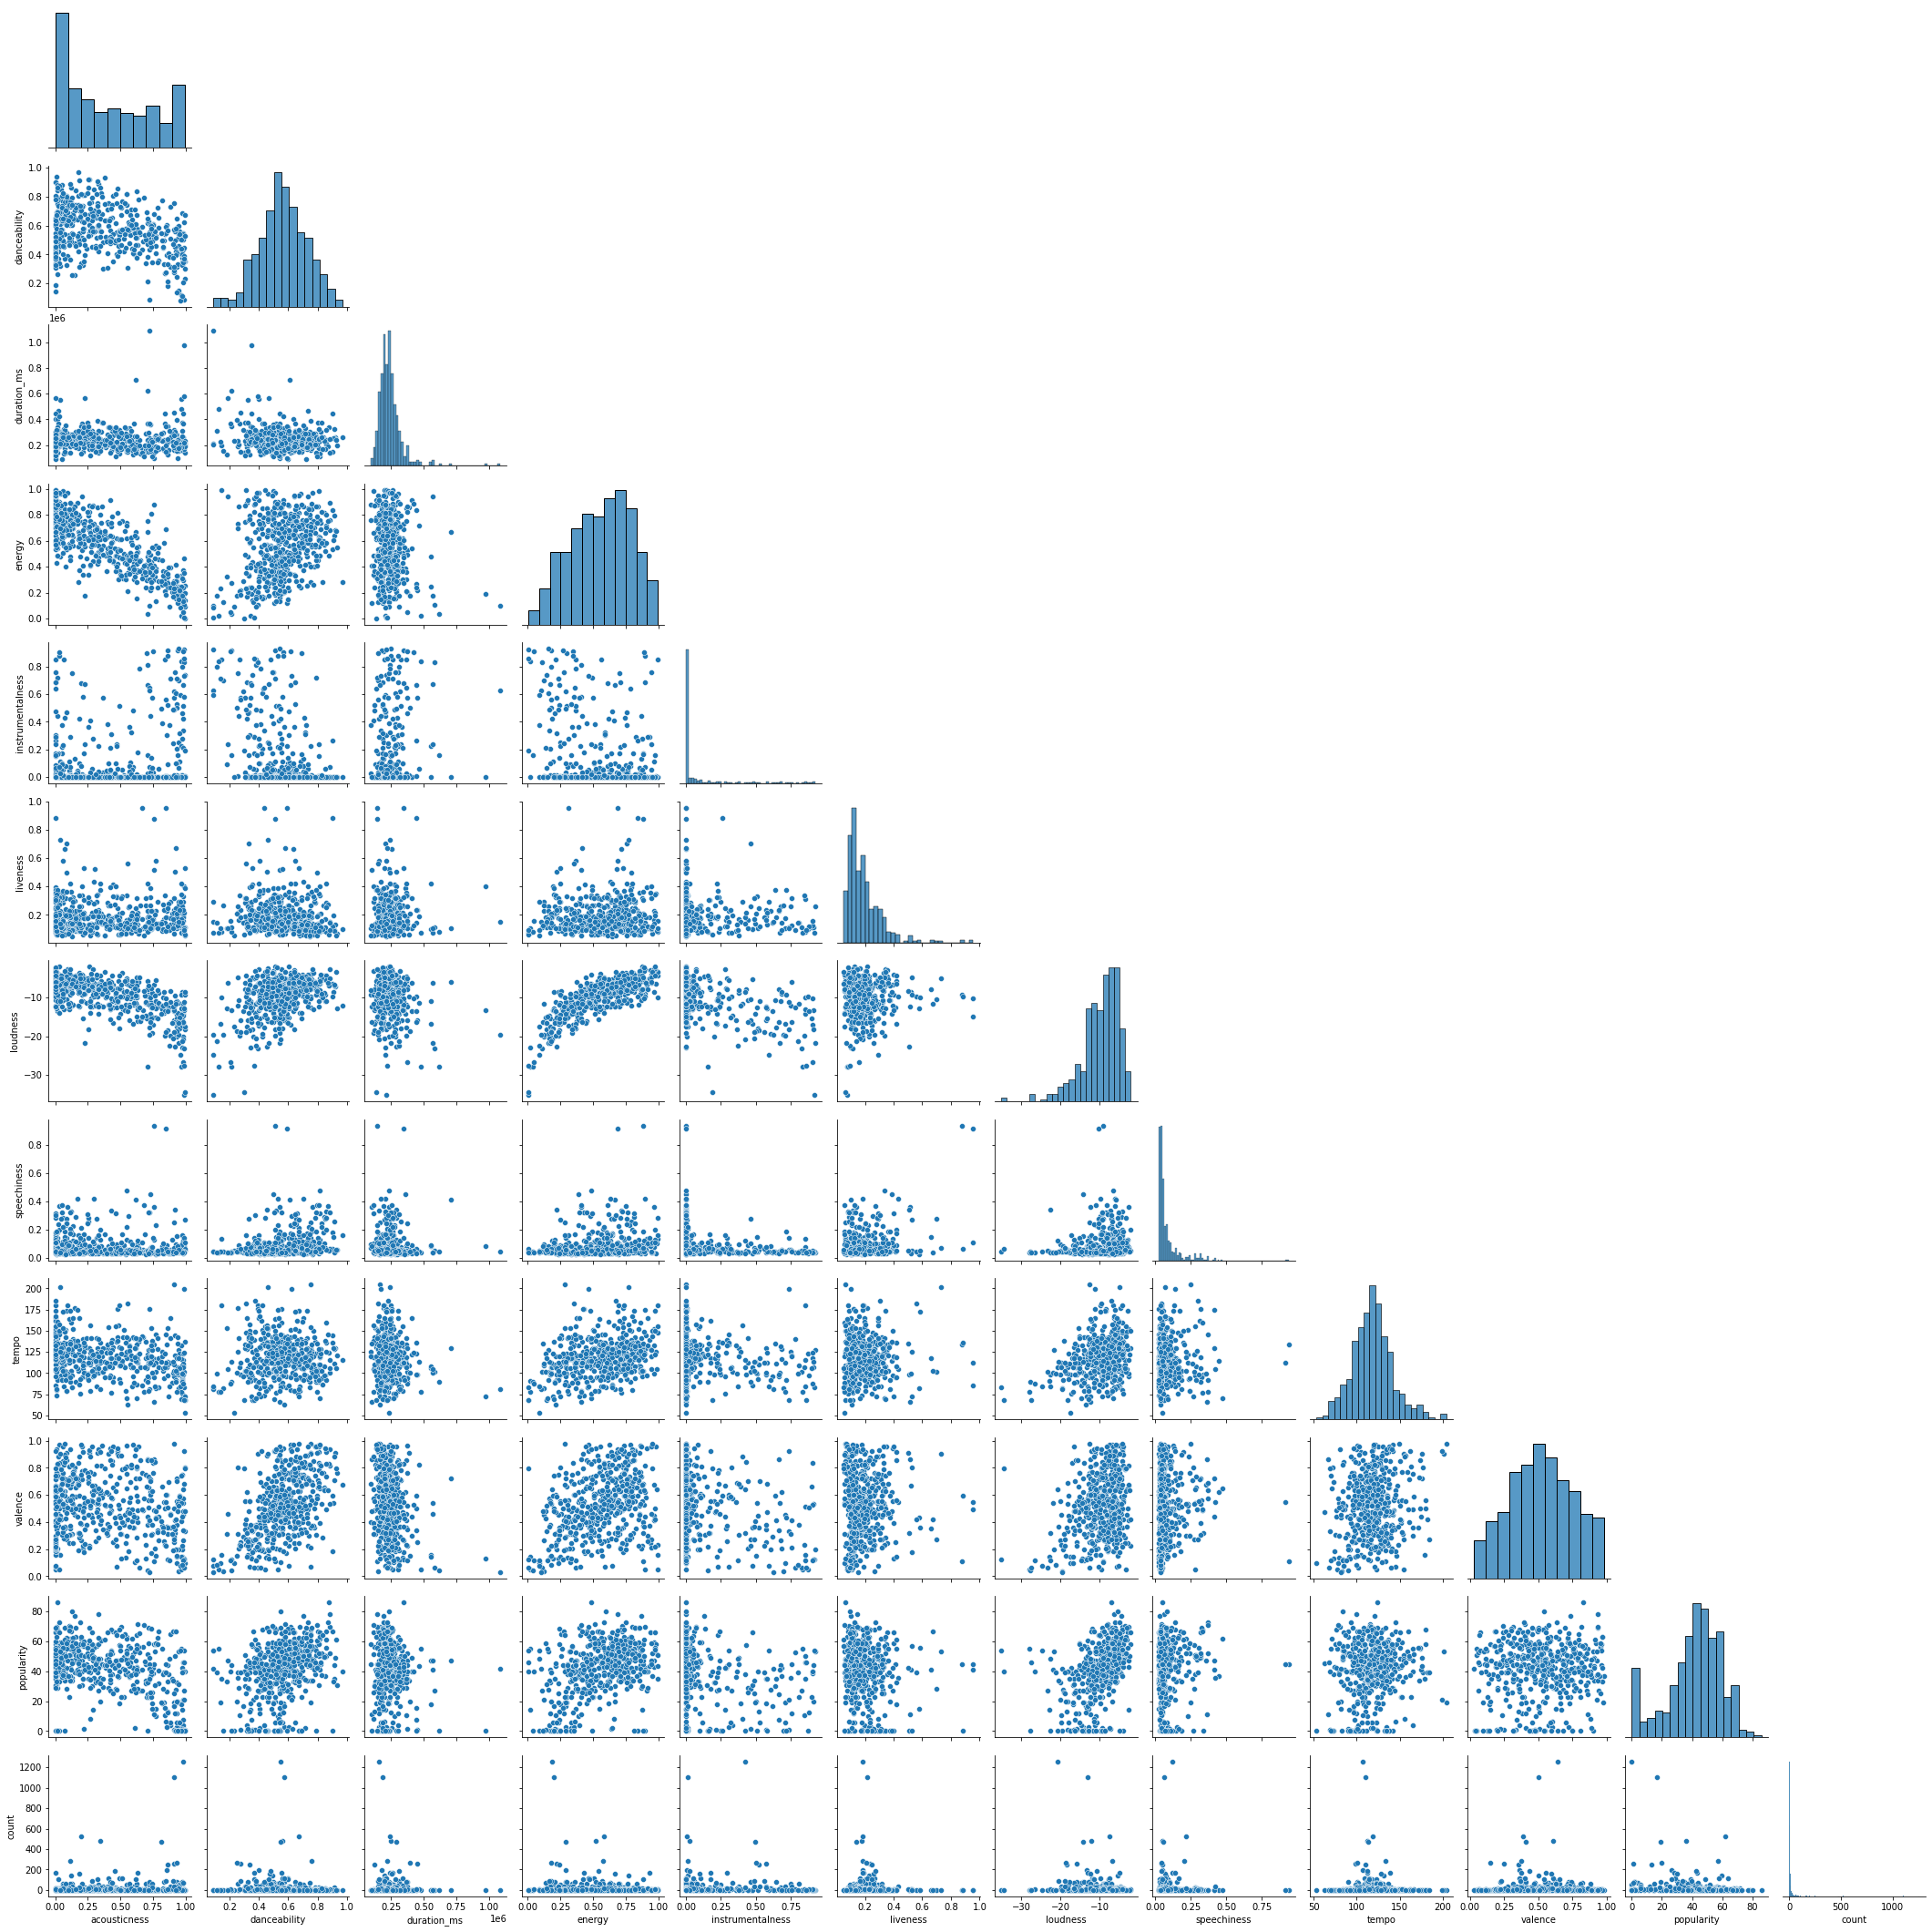

In [49]:
import seaborn as sns

sns.pairplot(num_cols_df.drop(['key','mode'],axis=1).sample(500), corner=True)

You can start to see some correlation between some categories.

* It looks like **acousticness** is inversely related to **loudness** and **energy**, which makes sense.

* It looks like **danceability** is directly related to **valence** and maybe **loudness**.

* It looks like **energy** might be directly related to **valence** and **tempo** and definitely **loudness**.

* **Instrumentalness** and **speechiness** look inversely related, which again, makes a lot of sense.

Let's see how these shake out in a correlation heat map.

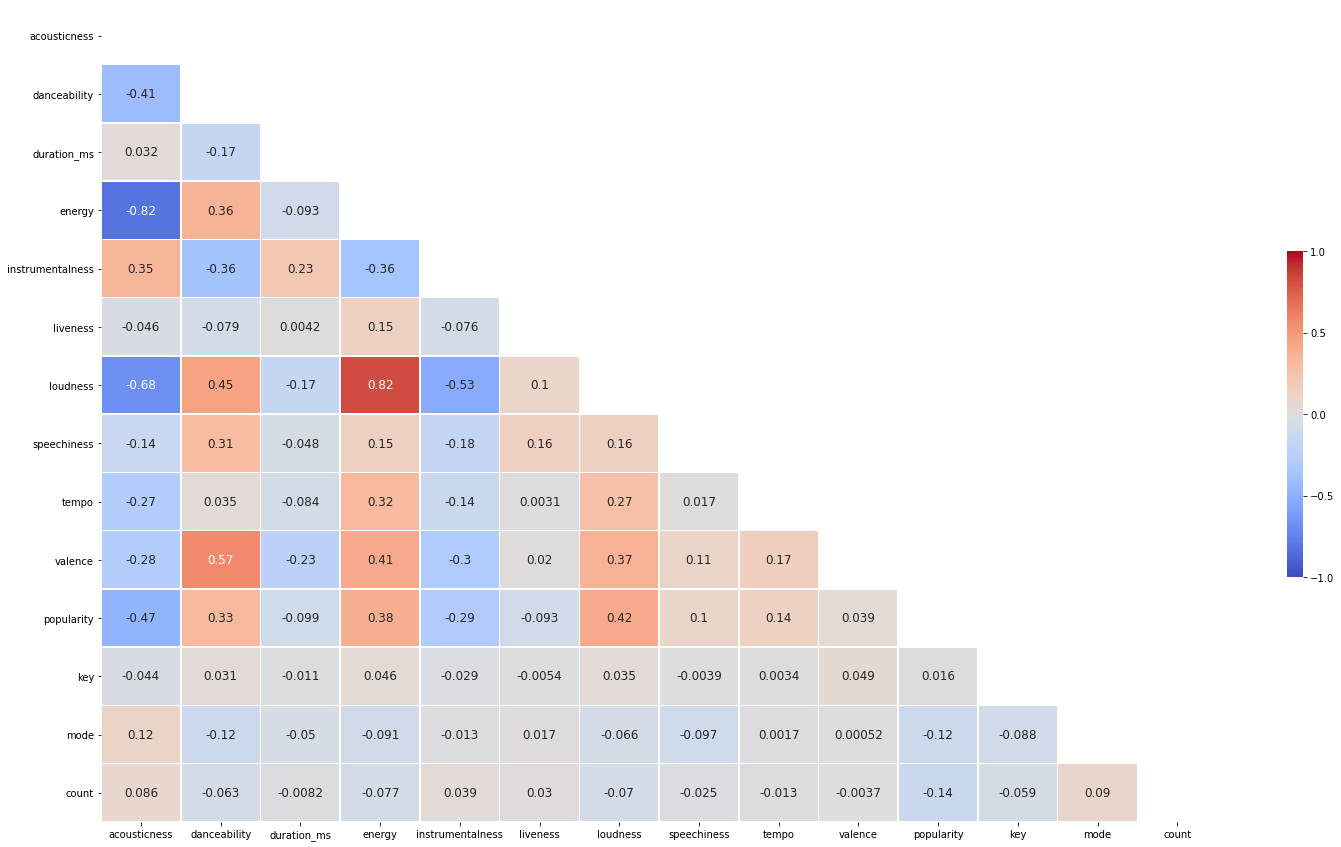

In [50]:
corr_matrix = num_cols_df.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f, ax = plt.subplots(figsize=(25,15))

heatmap = sns.heatmap(corr_matrix,
                      mask=mask,
                      linewidths=.5,
                      cmap='coolwarm',
                      cbar_kws = {'shrink': .4,
                                  'ticks': [-1,-.5,0,.5,1]},
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size':12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [51]:
feature_corr = FeatureCorrelationDict(num_cols_df, .5)
pd.DataFrame(feature_corr).dropna(axis=1,how='all').replace(np.nan, '')

acousticness danceability  ... loudness valence
energy                  -0.82               ...     0.82        
loudness                -0.68               ...                 
valence                               0.57  ...                 
acousticness                                ...    -0.68        
instrumentalness                            ...    -0.53        
danceability                                ...             0.57

[6 rows x 6 columns]

* The strongest correlations exist between energy/acousticness and energy/loudness.

* I will try keeping loudness and dropping energy, acousticness, and instrumentalness.

* I will keep danceability and drop valence.

* I will also drop count as I don't think that's a very helpful metric.

In [52]:
num_cols_df.drop(columns=['energy','acousticness','instrumentalness','count', 'valence'], inplace=True)

In [53]:
feature_corr = FeatureCorrelationDict(num_cols_df, .4)
pd.DataFrame(feature_corr).dropna(axis=1,how='all').replace(np.nan, '')

danceability loudness popularity
loudness             0.45                0.42
danceability                  0.45           
popularity                    0.42

Okay I've made it so there is no correlation above .5.

# Preparing the Data for Machine Learning

In [54]:
scaler = StandardScaler
num_cols_std = scaler().fit_transform(num_cols_df)
num_cols_std_df = pd.DataFrame(num_cols_std)
num_cols_std_df.columns = num_cols_df.columns
pd.DataFrame(num_cols_std_df).describe()

danceability   duration_ms  ...           key          mode
count  1.549300e+04  1.549300e+04  ...  1.549300e+04  1.549300e+04
mean   1.985689e-16  2.151581e-18  ... -4.623481e-17 -7.880699e-16
std    1.000032e+00  1.000032e+00  ...  1.000032e+00  1.000032e+00
min   -3.055813e+00 -2.461023e+00  ... -1.560323e+00 -1.814629e+00
25%   -6.443196e-01 -5.593495e-01  ... -9.891222e-01  5.510768e-01
50%    4.346488e-02 -1.602931e-01  ...  1.532801e-01  5.510768e-01
75%    7.201234e-01  3.117552e-01  ...  1.010082e+00  5.510768e-01
max    2.552867e+00  1.967211e+01  ...  1.581283e+00  5.510768e-01

[8 rows x 9 columns]

You can see that the means are all very close to zero and the standard deviation is very close to one. Standardization complete!

In [55]:
X_notags = num_cols_std_df
X_notags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15493 entries, 0 to 15492
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   danceability  15493 non-null  float64
 1   duration_ms   15493 non-null  float64
 2   liveness      15493 non-null  float64
 3   loudness      15493 non-null  float64
 4   speechiness   15493 non-null  float64
 5   tempo         15493 non-null  float64
 6   popularity    15493 non-null  float64
 7   key           15493 non-null  float64
 8   mode          15493 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB


In [56]:
genres_tags_nozero_df.index = np.arange(0,15493)
X_all = pd.concat([num_cols_std_df, genres_tags_nozero_df], axis=1)
X_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15493 entries, 0 to 15492
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   danceability  15493 non-null  float64
 1   duration_ms   15493 non-null  float64
 2   liveness      15493 non-null  float64
 3   loudness      15493 non-null  float64
 4   speechiness   15493 non-null  float64
 5   tempo         15493 non-null  float64
 6   popularity    15493 non-null  float64
 7   key           15493 non-null  float64
 8   mode          15493 non-null  float64
 9   pop           15493 non-null  int8   
 10  rock          15493 non-null  int8   
 11  rap           15493 non-null  int8   
 12  alternative   15493 non-null  int8   
 13  hiphop        15493 non-null  int8   
 14  indie         15493 non-null  int8   
 15  classic       15493 non-null  int8   
 16  dance         15493 non-null  int8   
 17  folk          15493 non-null  int8   
 18  new           15493 non-nu

In [57]:
X_all.head()

danceability  duration_ms  liveness  ...  orchestra  punk  banda
0     -0.595433     0.070475  0.825353  ...          0     0      0
1      0.591388    -0.272532 -0.247971  ...          0     0      0
2      1.362190    -1.158607 -0.089135  ...          0     0      0
3      1.927792    -1.119151 -0.947915  ...          0     0      0
4      1.751800    -0.582800 -0.021293  ...          0     0      0

[5 rows x 43 columns]

# Unsupervised Learning

I am interested in how the artists cluster. I want to profile each cluster and compare them, but first I want to prepare the data in a few different ways to try in clustering. I will see how PCA visualizes clusters, but will most likely use UMAP as my visualization for clustering, and may even pass its dimensionality reduction through different clustering techniques.

## Principal Component Analysis (PCA)

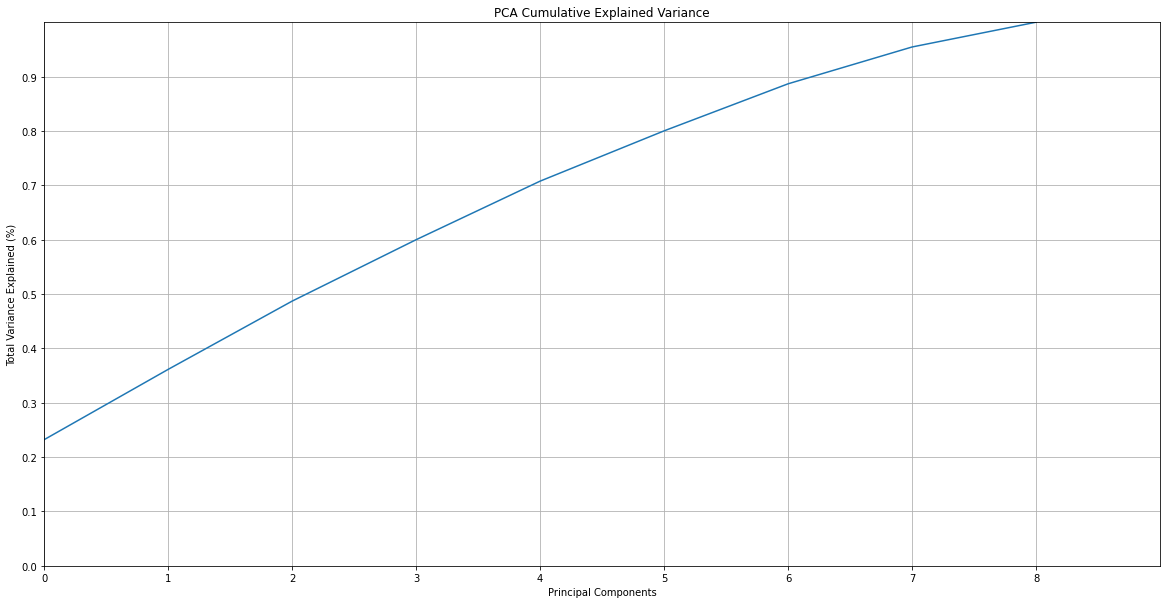

In [58]:
pca_scree = PCA(n_components=9).fit(X_notags)

plt.figure(figsize=(20,10))
plt.title('PCA Cumulative Explained Variance')

plt.xlabel('Principal Components')
plt.xlim(0,9)
plt.xticks(ticks=np.arange(0,9,1))

plt.ylabel('Total Variance Explained (%)')
plt.ylim(0,1.0)
plt.yticks(ticks=np.arange(0,1.0,.1))

plt.style.context('seaborn')
plt.grid(which='both' ,axis='both')

plt.plot(np.cumsum(pca_scree.explained_variance_ratio_))
plt.show()

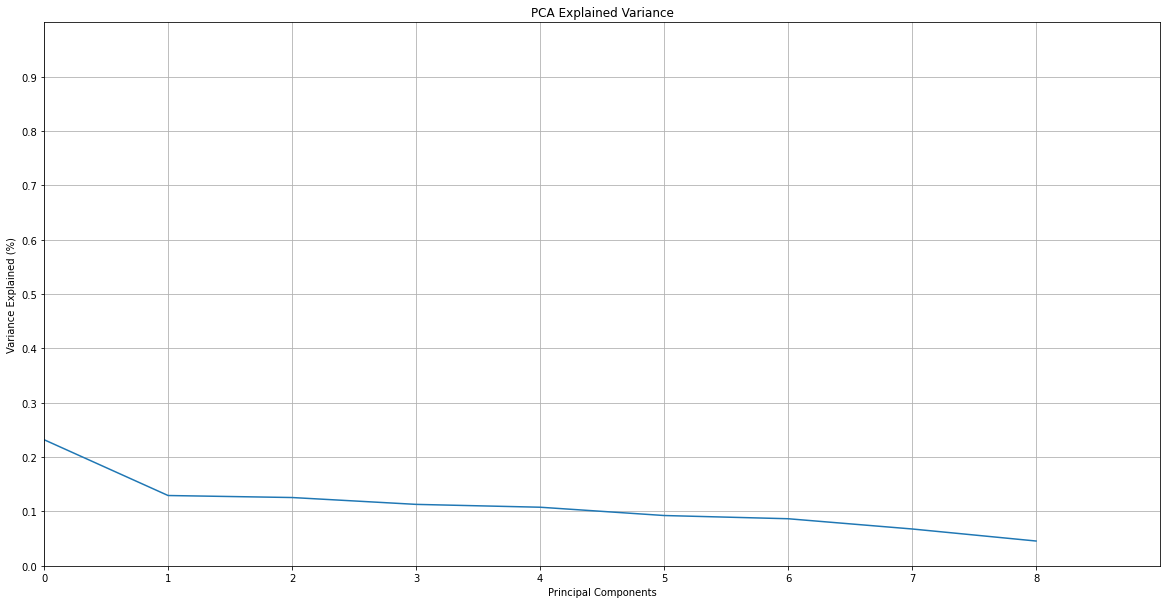

In [59]:
plt.figure(figsize=(20,10))

plt.title('PCA Explained Variance')

plt.xlabel('Principal Components')
plt.xlim(0,9)
plt.xticks(ticks=np.arange(0,9,1))

plt.ylabel('Variance Explained (%)')
plt.ylim(0,1.0)
plt.yticks(ticks=np.arange(0,1.0,.1))

plt.style.context('seaborn')
plt.grid(which='both' ,axis='both')

plt.plot(pca_scree.explained_variance_ratio_)
plt.show()

It seems that PCA on just the continuous variables (no tags) does not have a real elbow past 1 principle component (probably not a great idea) 

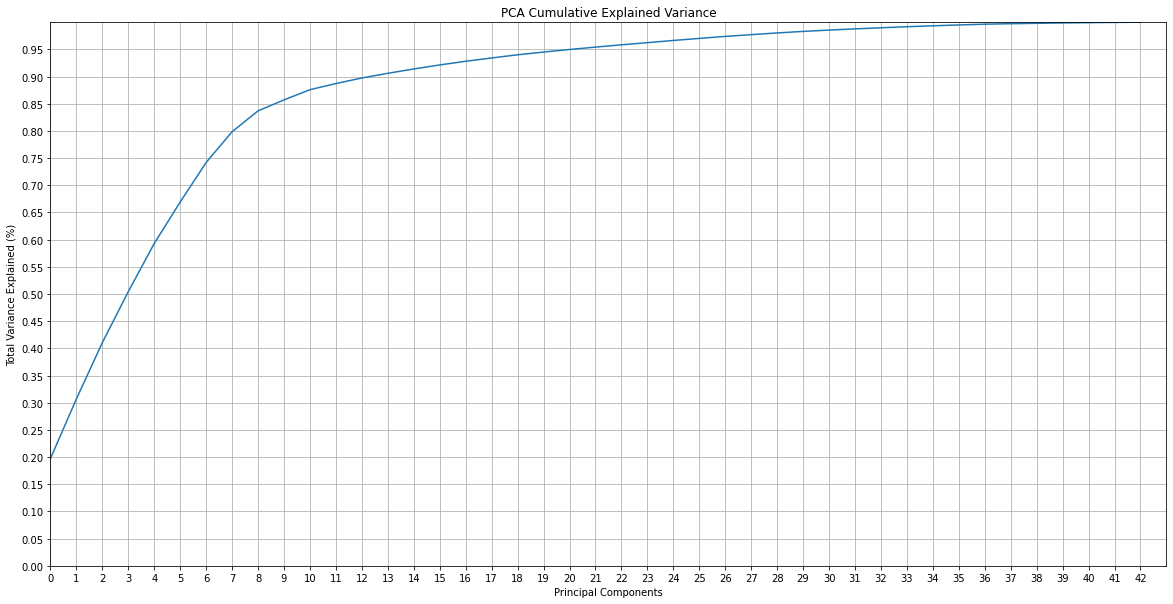

In [60]:
pca_scree = PCA(n_components=43).fit(X_all)

plt.figure(figsize=(20,10))
plt.title('PCA Cumulative Explained Variance')

plt.xlabel('Principal Components')
plt.xlim(0,43)
plt.xticks(ticks=np.arange(0,43,1))

plt.ylabel('Total Variance Explained (%)')
plt.ylim(0,1.0)
plt.yticks(ticks=np.arange(0,1.0,.05))

plt.style.context('seaborn')
plt.grid(which='both' ,axis='both')

plt.plot(np.cumsum(pca_scree.explained_variance_ratio_))
plt.show()

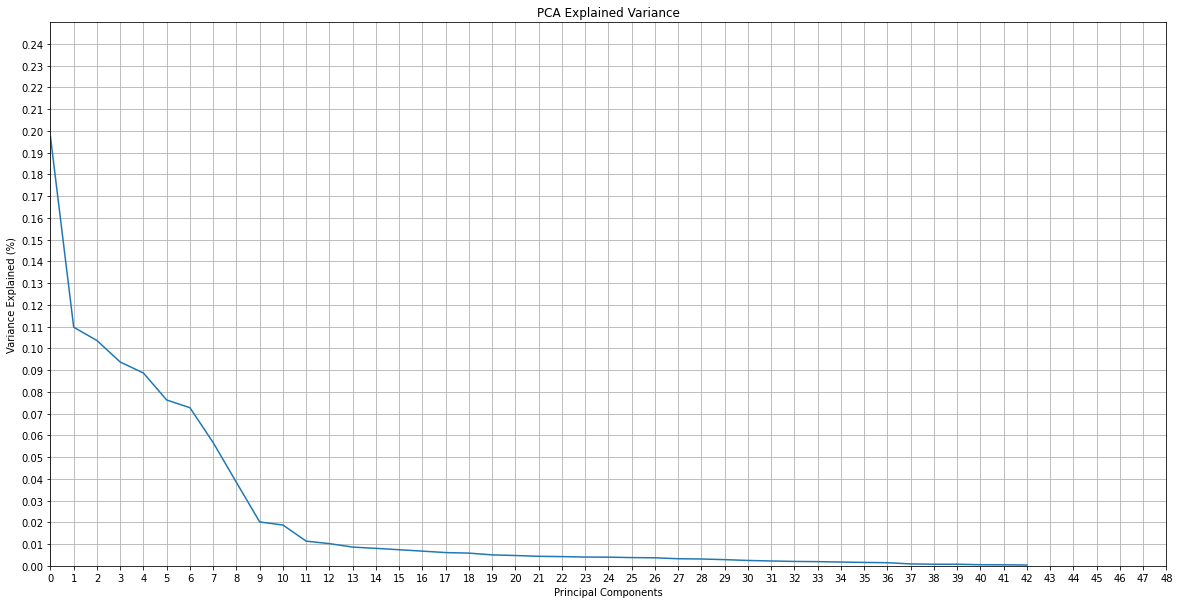

In [61]:
plt.figure(figsize=(20,10))

plt.title('PCA Explained Variance')

plt.xlabel('Principal Components')
plt.xlim(0,14)
plt.xticks(ticks=np.arange(0,49,1))

plt.ylabel('Variance Explained (%)')
plt.ylim(0,0.25)
plt.yticks(ticks=np.arange(0,0.25,.01))

plt.style.context('seaborn')
plt.grid(which='both' ,axis='both')

plt.plot(pca_scree.explained_variance_ratio_)
plt.show()

I would use the first 10 components if using the genre tags. That's interesting because it's the same as the number of features without the genre tags. Given that both really need at least 8 components, I don't imagine the PCA 2D visualization will provide meaningful clusters of artists, but I would like to see it anyways.

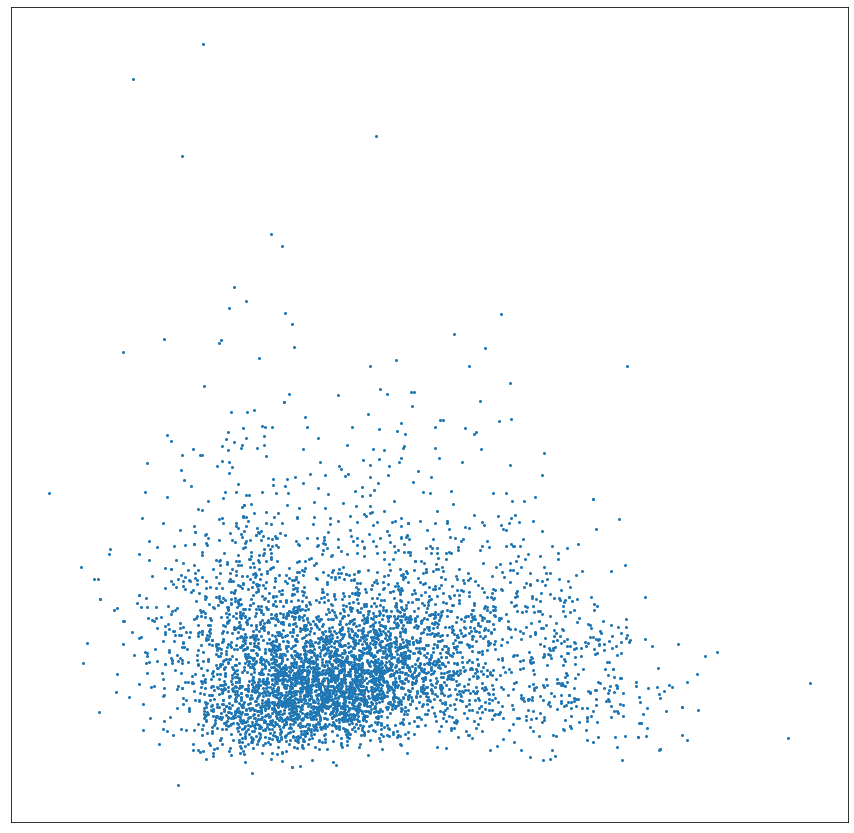

In [62]:
pca = PCA(n_components=2).fit_transform(X_notags.sample(5000))

plt.figure(figsize=(15,15))
plt.scatter(pca[:,0],pca[:,1],s=4)
plt.xticks([])
plt.yticks([])
plt.show()

Not surprised, but still disappointed.

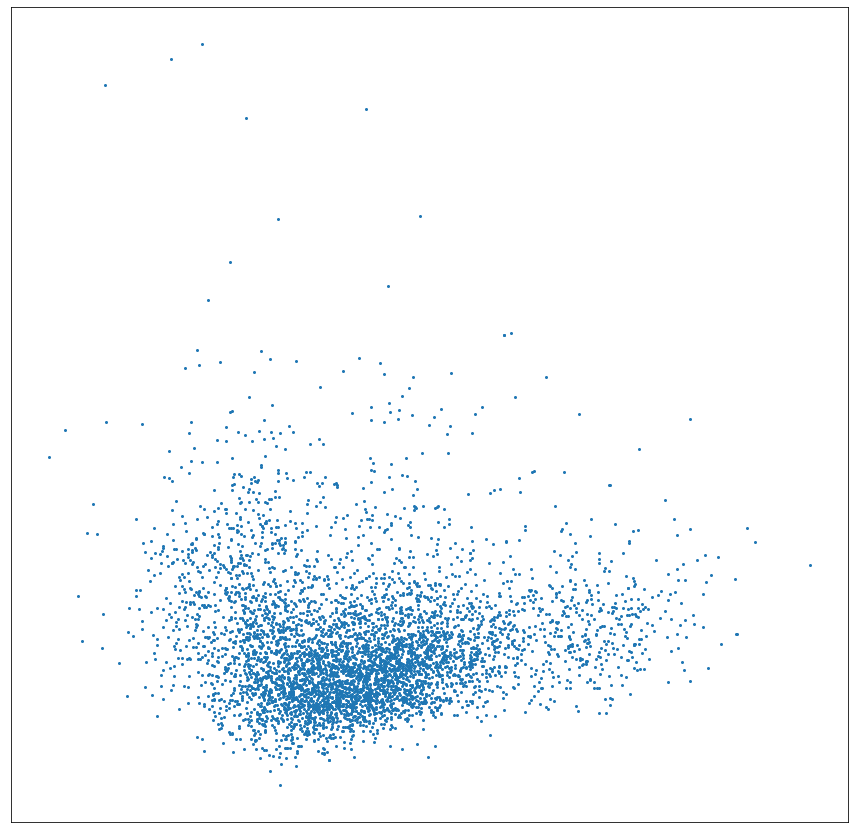

In [63]:
pca = PCA(n_components=2).fit_transform(X_all.sample(5000))

plt.figure(figsize=(15,15))
plt.scatter(pca[:,0],pca[:,1],s=4)
plt.xticks([])
plt.yticks([])
plt.show()

Also not surprised that they look the same as the first two principal components are probably the same.

## Uniform Manifold Approximation and Projection (UMAP)

### All Columns

Plot done! Total time elapsed: 21.462456464767456 seconds


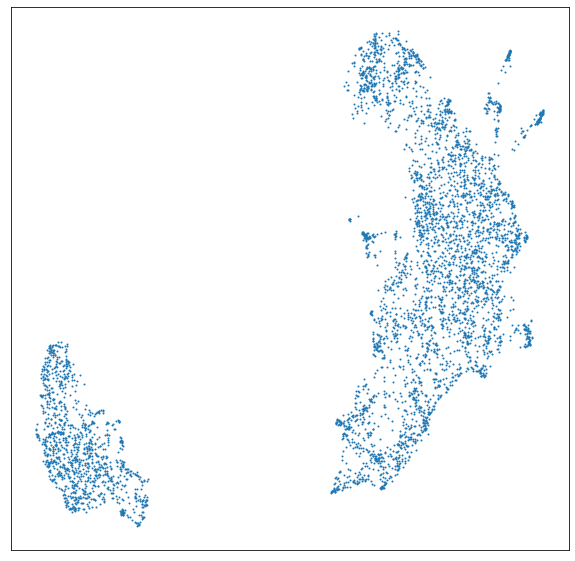

In [64]:
#Start the timer
time_start = time.time()

# Run UMAP with default params
umap_results = umap.UMAP().fit_transform(X_all.sample(5000))

# Plot the results
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.scatter(umap_results[:, 0], umap_results[:, 1],
            s=1, cmap='Spectral');

print('Plot done! Total time elapsed: {} seconds'.format(time.time()-time_start))

I just want to see what happens if I pass a PCA transformed dataset into UMAP's visualization.

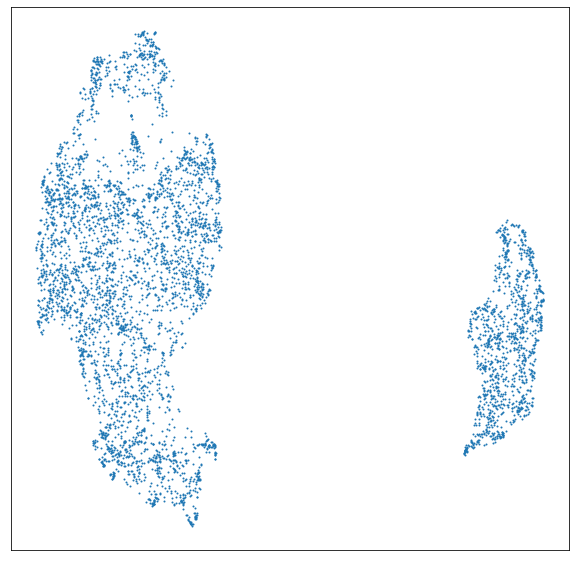

In [65]:
pca_tags_8 = PCA(n_components=8).fit_transform(X_all.sample(5000))

# Run UMAP with default params
umap_results = umap.UMAP().fit_transform(pca_tags_8)

# Plot the results
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.scatter(umap_results[:, 0], umap_results[:, 1],
            s=1, cmap='Spectral');

### No Genre Tags

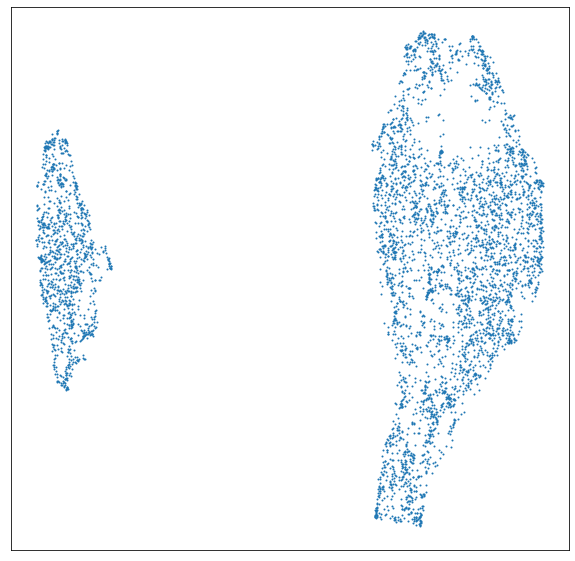

Plot done! Total time elapsed: 12.216190338134766 seconds


In [66]:
#Start the timer
time_start = time.time()

# Run UMAP with default params
umap_results = umap.UMAP().fit_transform(X_notags.sample(5000))

# Plot the results
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.scatter(umap_results[:, 0], umap_results[:, 1], s=1, cmap='Spectral')
plt.show()

print('Plot done! Total time elapsed: {} seconds'.format(time.time()-time_start))

## Simplifying the Clustering Problem: 3 different genre tags.

I'm not getting many good clusters. I'm going to pick 3 pretty disparate genres and see if I can generate three separate clusters. I'm also going to sample them at 1000 so that they are reasonably balanced in class.

In [147]:
rap_df = X_all[(X_all['rap']==1)]
country_df = X_all[(X_all['country']==1)]
classical_df = X_all[(X_all['classical']==1)]

three_genre_df = pd.concat([rap_df, country_df, classical_df], axis=0)
print(three_genre_df.head())
print('**********')
print('**********')
print(f'Number of artists with rap tag = {rap_df.shape[0]}')
print(f'Number of artists with country tag = {country_df.shape[0]}')
print(f'Number of artists with classical tag = {classical_df.shape[0]}')
print(f'Number of total artists = {three_genre_df.shape[0]}')

    danceability  duration_ms  liveness  ...  orchestra  punk  banda
2       1.362190    -1.158607 -0.089135  ...          0     0      0
3       1.927792    -1.119151 -0.947915  ...          0     0      0
4       1.751800    -0.582800 -0.021293  ...          0     0      0
5       1.116676    -1.065931  0.092490  ...          0     0      0
12      0.144812     0.107201 -0.165085  ...          0     0      0

[5 rows x 43 columns]
**********
**********
Number of artists with rap tag = 2019
Number of artists with country tag = 1071
Number of artists with classical tag = 1194
Number of total artists = 4284


In [148]:
three_genre_df.drop_duplicates(inplace=True, keep='first')
print(f'After dropping duplicates, the number of artists remaining is {three_genre_df.shape[0]}')

After dropping duplicates, the number of artists remaining is 4168


In [149]:
# Fixing the index
three_genre_df.index=np.arange(0,three_genre_df.shape[0])
three_genre_df.head()

danceability  duration_ms  liveness  ...  orchestra  punk  banda
0      1.362190    -1.158607 -0.089135  ...          0     0      0
1      1.927792    -1.119151 -0.947915  ...          0     0      0
2      1.751800    -0.582800 -0.021293  ...          0     0      0
3      1.116676    -1.065931  0.092490  ...          0     0      0
4      0.144812     0.107201 -0.165085  ...          0     0      0

[5 rows x 43 columns]

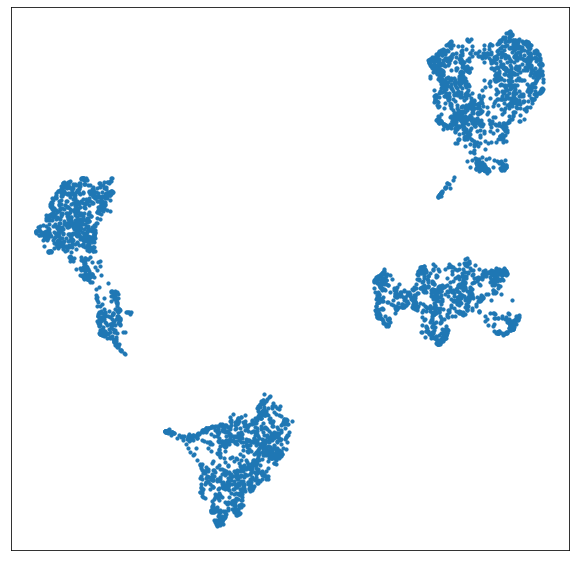

Plot done! Total time elapsed: 10.64647650718689 seconds


In [150]:
#Start the timer
time_start = time.time()

# Run UMAP with default params
umap_results = umap.UMAP().fit_transform(three_genre_df)

# Create the plot
fig = plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.scatter(umap_results[:, 0], umap_results[:, 1], s=10)
plt.show()

print('Plot done! Total time elapsed: {} seconds'.format(time.time()-time_start))

Okay that looks a lot like five clusters, which means perhaps two of the genres have a sub genre. Let's use KMeans to set the number of clusters and then get a profile of each.

### Using KMeans Clustering To Analyze 3 Genre Problem

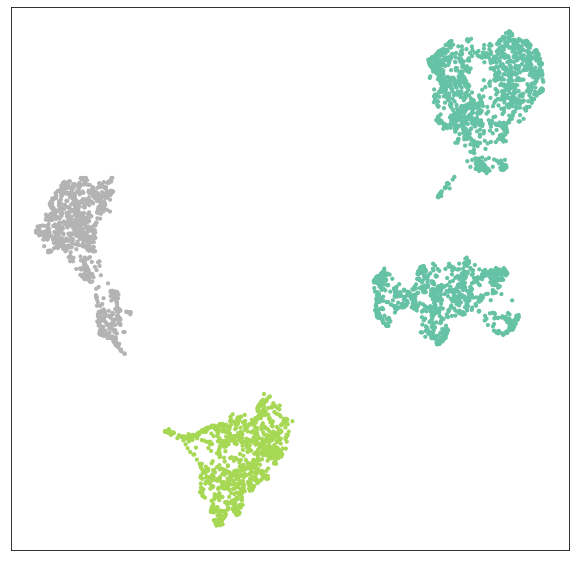

Silhouette Score = 0.6695705652236938
Done! Time elapsed: 0.54183030128479 seconds


In [151]:
# Start the timer
time_start = time.time()

# Defining the k-means
kmeans_cluster = KMeans(n_clusters=3)

# Fit model
kmeans_cluster.fit(umap_results)
y_pred = kmeans_cluster.predict(umap_results)

# Create the plot
fig = plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=y_pred, s=10, cmap='Set2')
plt.show()

# Get the silhouette score
silhouette_score = sklearn.metrics.silhouette_score(umap_results, y_pred)
print(f'Silhouette Score = {silhouette_score}')

print('Done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [152]:
clustering_umap = umap.UMAP().fit_transform(three_genre_df)

for i in range(2,30):
  # Defining the k-means
  kmeans_cluster = KMeans(n_clusters=i)

  # Fit model
  kmeans_cluster.fit(clustering_umap)
  y_pred = kmeans_cluster.predict(clustering_umap)

  # Get the silhouette score
  silhouette_score = sklearn.metrics.silhouette_score(clustering_umap, y_pred)
  print(f'Number of Clusters = {i} | Silhouette Score = {silhouette_score}')

Number of Clusters = 2 | Silhouette Score = 0.6007219552993774
Number of Clusters = 3 | Silhouette Score = 0.6846827864646912
Number of Clusters = 4 | Silhouette Score = 0.7282868027687073
Number of Clusters = 5 | Silhouette Score = 0.6868597865104675
Number of Clusters = 6 | Silhouette Score = 0.5797535181045532
Number of Clusters = 7 | Silhouette Score = 0.5413883924484253
Number of Clusters = 8 | Silhouette Score = 0.5635406374931335
Number of Clusters = 9 | Silhouette Score = 0.4871107339859009
Number of Clusters = 10 | Silhouette Score = 0.5035576820373535
Number of Clusters = 11 | Silhouette Score = 0.47161537408828735
Number of Clusters = 12 | Silhouette Score = 0.4616442918777466
Number of Clusters = 13 | Silhouette Score = 0.4610985219478607
Number of Clusters = 14 | Silhouette Score = 0.4723167419433594
Number of Clusters = 15 | Silhouette Score = 0.4629654884338379
Number of Clusters = 16 | Silhouette Score = 0.4601627588272095
Number of Clusters = 17 | Silhouette Score = 0.

Well that's not so bad! Let's see if we can achieve a higher score with a density-based clustering technique called DBSCAN.

### Using DBSCAN Clustering to Analyze 3 Genre Problem

Silhouette Score for eps = 0.2 giving 10 clusters: 0.20070186257362366
Silhouette Score for eps = 0.25 giving 7 clusters: 0.522026777267456
Silhouette Score for eps = 0.333 giving 6 clusters: 0.5660555362701416
Silhouette Score for eps = 0.5 giving 5 clusters: 0.5809779763221741
Silhouette Score for eps = 1.0 giving 4 clusters: 0.7255435585975647


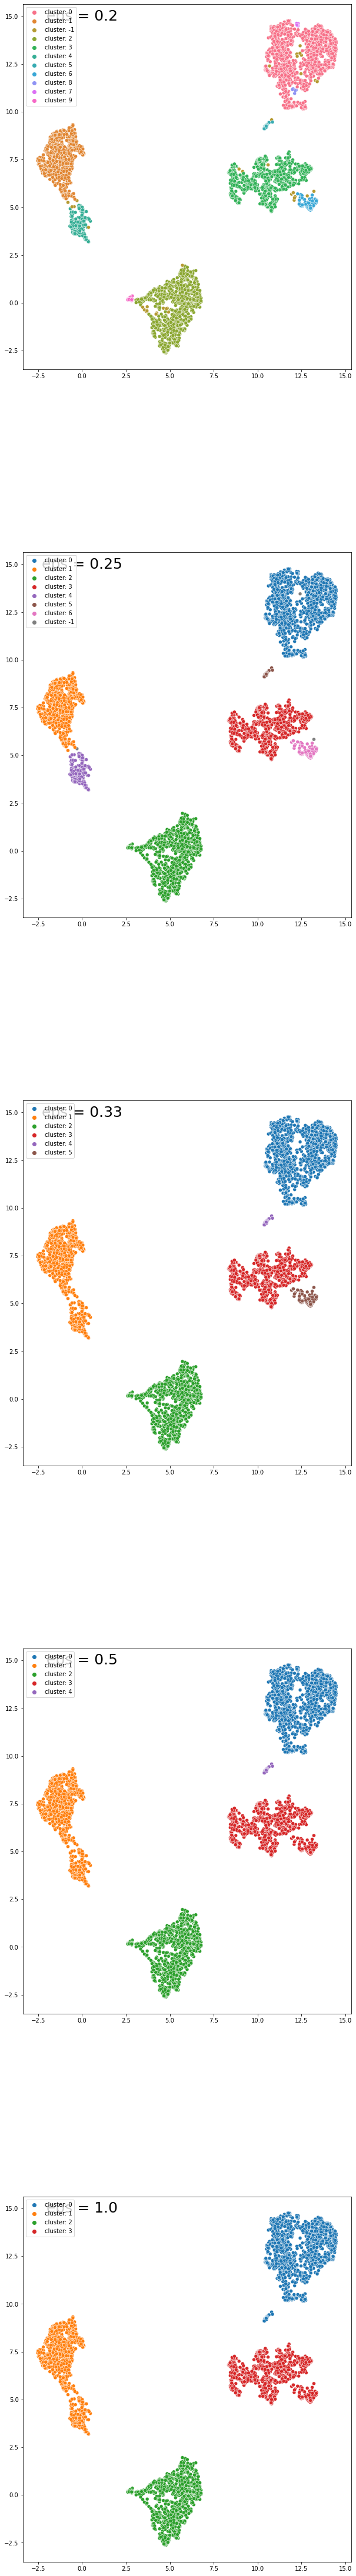

In [173]:
fig = plt.figure(figsize=(10, 80))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in np.arange(1,6):
    eps = 1/(6-x)
    db = DBSCAN(eps=eps).fit(clustering_umap)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    ax = fig.add_subplot(5, 1, i)
    ax.text(0, 15, "eps = {}".format(round(eps, 2)), fontsize=25, va="center", ha="center")
    sns.scatterplot(clustering_umap[:,0], clustering_umap[:,1], hue=["cluster: {}".format(x) for x in labels])
    silhouette_score = sklearn.metrics.silhouette_score(clustering_umap, labels)
    print(f'Silhouette Score for eps = {round(eps,3)} giving {max(labels)+1} clusters: {silhouette_score}')
    
    i += 1

Well I am getting my highest Silhouette Scores with KMeans so far at 4 clusters. I'm going to set a specific random_state for Kmeans going forward so I have consistent clusters to analyze.

###Visualizing Clusters Different Ways

I want to see how the clusters are looking in 3D and I also want to create one with hover where I can see the genre breakdown of each point.

##### MatPlotLib

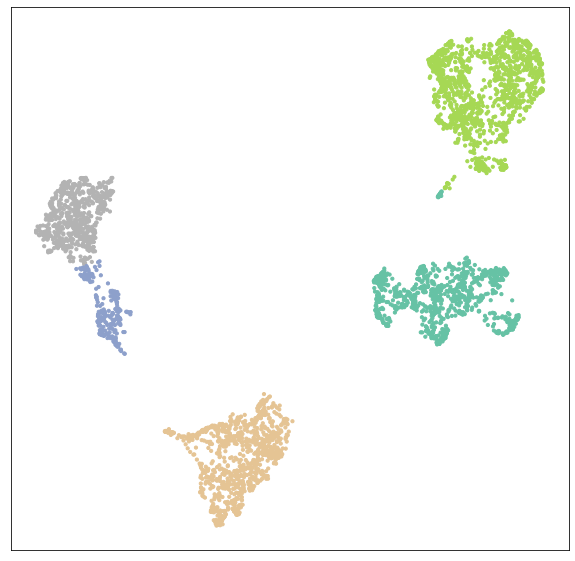

Silhouette Score = 0.6957412362098694
Done! Time elapsed: 0.563077449798584 seconds


In [294]:
# Start the timer
time_start = time.time()

# Defining the k-means
kmeans_cluster = KMeans(n_clusters=5, random_state=66)

# Fit model
kmeans_cluster.fit(umap_results)
clusters = kmeans_cluster.predict(umap_results)

# Create the plot
fig = plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=clusters, s=10, cmap='Set2')
plt.show()

# Get the silhouette score
silhouette_score = sklearn.metrics.silhouette_score(umap_results, clusters)
print(f'Silhouette Score = {silhouette_score}')

print('Done! Time elapsed: {} seconds'.format(time.time()-time_start))

##### In 3D

In [180]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title='', data=three_genre_df, clusters=clusters):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
    )
    u = fit.fit_transform(data);
    fig = plt.figure(figsize=(10,10))
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=clusters)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=clusters)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=clusters, s=10)
    plt.title(title, fontsize=18)

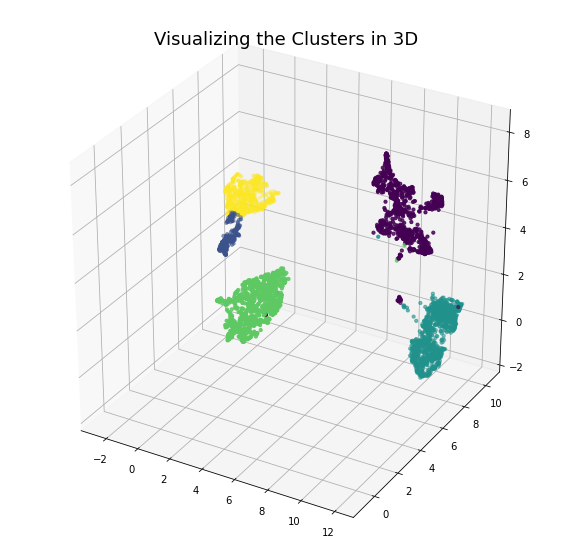

In [181]:
draw_umap(n_components=3, title='Visualizing the Clusters in 3D', data=three_genre_df, clusters=clusters)

##### Using Plotly For Hover and Size

In [182]:
# Creating a dataframe just for plotting.
df = pd.concat([three_genre_df, pd.DataFrame(umap_results).rename(columns={0:'umap_0',1:'umap_1'})], axis=1)
df[df.columns[:8]] -= df[df.columns[:8]].min()

# Making the cluster label a string so plotly recognizes as categorical variable for coloring
df['cluster']=clusters.astype(str)

In [183]:
# Making the cluster label a string so plotly recognizes as categorical variable for coloring
fig = px.scatter(df, x="umap_0", y="umap_1",
                 title='<b>Clusters Sized by Danceability</b>',
                 hover_name="cluster", 
                 hover_data=["country", "classical","rap"],
                 color='cluster',
                 size='danceability',
                 width=800,
                 height=800,
                 )

fig.update_layout(yaxis_visible=False, yaxis_showticklabels=False,
                  xaxis_visible=False, xaxis_showticklabels=False,)

fig.show()

In [184]:
# Making the cluster label a string so plotly recognizes as categorical variable for coloring
fig = px.scatter(df, x="umap_0", y="umap_1",
                 title='<b>Clusters Sized by Duration</b>',
                 hover_name="cluster", 
                 hover_data=["country", "classical","rap"],
                 color='cluster',
                 size='duration_ms',
                 width=800,
                 height=800,
                 )

fig.update_layout(yaxis_visible=False, yaxis_showticklabels=False,
                  xaxis_visible=False, xaxis_showticklabels=False,)

fig.show()

In [185]:
# Making the cluster label a string so plotly recognizes as categorical variable for coloring
fig = px.scatter(df, x="umap_0", y="umap_1",
                 title='<b>Clusters Sized by Liveness</b>',
                 hover_name="cluster", 
                 hover_data=["country", "classical","rap"],
                 color='cluster',
                 size='liveness',
                 width=800,
                 height=800,
                 )

fig.update_layout(yaxis_visible=False, yaxis_showticklabels=False,
                  xaxis_visible=False, xaxis_showticklabels=False,)

fig.show()

In [186]:
# Making the cluster label a string so plotly recognizes as categorical variable for coloring
fig = px.scatter(df, x="umap_0", y="umap_1",
                 title='<b>Clusters Sized by Loudness</b>',
                 hover_name="cluster", 
                 hover_data=["country", "classical","rap"],
                 color='cluster',
                 size='loudness',
                 width=800,
                 height=800,
                 )

fig.update_layout(yaxis_visible=False, yaxis_showticklabels=False,
                  xaxis_visible=False, xaxis_showticklabels=False,)

fig.show()

In [188]:
# Making the cluster label a string so plotly recognizes as categorical variable for coloring
fig = px.scatter(df, x="umap_0", y="umap_1",
                 title='<b>Clusters Sized by Speechiness</b>',
                 hover_name="cluster", 
                 hover_data=["country", "classical","rap"],
                 color='cluster',
                 size='speechiness',
                 width=800,
                 height=800,
                 )

fig.update_layout(yaxis_visible=False, yaxis_showticklabels=False,
                  xaxis_visible=False, xaxis_showticklabels=False,)

fig.show()

I think speechiness shows how the red cluster (4) and the orange cluster (1) are separated.

In [189]:
# Making the cluster label a string so plotly recognizes as categorical variable for coloring
fig = px.scatter(df, x="umap_0", y="umap_1",
                 title='<b>Clusters Sized by Tempo</b>',
                 hover_name="cluster", 
                 hover_data=["country", "classical","rap"],
                 color='cluster',
                 size='tempo',
                 width=800,
                 height=800,
                 )

fig.update_layout(yaxis_visible=False, yaxis_showticklabels=False,
                  xaxis_visible=False, xaxis_showticklabels=False,)

fig.show()

### Analyzing the clusters

I will add the clusters as a column to my dataframe in order to analyze the data by cluster.

In [231]:
three_genre_df['cluster']=clusters
three_genre_df.head()

danceability  duration_ms  liveness  ...  punk  banda  cluster
0      1.362190    -1.158607 -0.089135  ...     0      0        2
1      1.927792    -1.119151 -0.947915  ...     0      0        2
2      1.751800    -0.582800 -0.021293  ...     0      0        2
3      1.116676    -1.065931  0.092490  ...     0      0        2
4      0.144812     0.107201 -0.165085  ...     0      0        2

[5 rows x 44 columns]

The three genres that I chose were **rap, country, classical**. Let's see if we can tell which cluster is which!

In [295]:
three_genre_df[['rap','country','classical','cluster']].groupby(['cluster']).mean().transpose()

cluster           0         1         2         3         4
rap        0.016343  0.075397  0.980843  0.015991  0.952450
country    0.961185  0.119048  0.040613  0.007463  0.056196
classical  0.028601  0.805556  0.005364  0.976546  0.011527

In [233]:
cluster_0_df = three_genre_df[(three_genre_df['cluster']==0)]
cluster_1_df = three_genre_df[(three_genre_df['cluster']==1)]
cluster_2_df = three_genre_df[(three_genre_df['cluster']==2)]
cluster_3_df = three_genre_df[(three_genre_df['cluster']==3)]
cluster_4_df = three_genre_df[(three_genre_df['cluster']==4)]

#### Cluster 0

In [299]:
cluster_0_df.iloc[:,:9].describe()

danceability  duration_ms  ...         key        mode
count    979.000000   979.000000  ...  979.000000  979.000000
mean      -0.014298    -0.248764  ...    0.058177    0.538995
std        0.545883     0.581056  ...    0.936936    0.168719
min       -2.374907    -1.785683  ...   -1.560323   -1.814629
25%       -0.305485    -0.598868  ...   -0.989122    0.551077
50%        0.004018    -0.335275  ...    0.438881    0.551077
75%        0.313521    -0.006681  ...    1.010082    0.551077
max        2.155368     3.354252  ...    1.581283    0.551077

[8 rows x 9 columns]

In [300]:
pd.DataFrame(cluster_0_df.iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock  rap  alternative  ...  norteno  orchestra  punk  banda
0  257   563   16          107  ...        0          4    15      0

[1 rows x 34 columns]

In [301]:
pd.DataFrame(cluster_0_df[(cluster_0_df['country']==0)].iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock  rap  alternative  ...  norteno  orchestra  punk  banda
0    7    11   10            0  ...        0          4     1      0

[1 rows x 34 columns]

This is clearly a country cluster. Of the 38 songs not labeled country, 28 are labeled classical.

#### Cluster 1

In [214]:
cluster_0_df.iloc[:,:9].describe()

danceability  duration_ms  ...         key        mode
count    979.000000   979.000000  ...  979.000000  979.000000
mean      -0.014298    -0.248764  ...    0.058177    0.538995
std        0.545883     0.581056  ...    0.936936    0.168719
min       -2.374907    -1.785683  ...   -1.560323   -1.814629
25%       -0.305485    -0.598868  ...   -0.989122    0.551077
50%        0.004018    -0.335275  ...    0.438881    0.551077
75%        0.313521    -0.006681  ...    1.010082    0.551077
max        2.155368     3.354252  ...    1.581283    0.551077

[8 rows x 9 columns]

In [302]:
cluster_1_df.iloc[:,:9].describe()

danceability  duration_ms  ...         key          mode
count    252.000000   252.000000  ...  252.000000  2.520000e+02
mean      -1.186785     0.419453  ...    0.080747 -1.814629e+00
std        0.918613     1.602958  ...    0.969063  6.452108e-15
min       -3.004229    -2.300603  ...   -1.560323 -1.814629e+00
25%       -1.895480    -0.674415  ...   -0.703522 -1.814629e+00
50%       -1.286846     0.034289  ...    0.153280 -1.814629e+00
75%       -0.514854     1.078030  ...    1.010082 -1.814629e+00
max        1.763938     6.308759  ...    1.581283 -1.814629e+00

[8 rows x 9 columns]

In [303]:
pd.DataFrame(cluster_1_df.iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock  rap  alternative  ...  norteno  orchestra  punk  banda
0   11    38   19           12  ...        0         13     1      0

[1 rows x 34 columns]

In [304]:
pd.DataFrame(cluster_1_df[(cluster_1_df['classical']==0)].iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock  rap  alternative  ...  norteno  orchestra  punk  banda
0    6    26   19           12  ...        0          0     1      0

[1 rows x 34 columns]

This is clearly a classical cluster. Of the 49 songs without a classical tag, 30 have a country tag.

#### Cluster 2

In [305]:
cluster_2_df.iloc[:,:9].describe()

danceability  duration_ms  ...          key         mode
count   1305.000000  1305.000000  ...  1305.000000  1305.000000
mean       0.830186    -0.142486  ...    -0.180905     0.549264
std        0.786912     0.578145  ...     1.063992     0.065487
min       -2.623966    -2.229531  ...    -1.560323    -1.814629
25%        0.380277    -0.489315  ...    -1.274723     0.551077
50%        0.962871    -0.124541  ...    -0.132320     0.551077
75%        1.366944     0.186296  ...     0.724481     0.551077
max        2.552867     3.228276  ...     1.581283     0.551077

[8 rows x 9 columns]

In [306]:
pd.DataFrame(cluster_2_df.iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock   rap  alternative  ...  norteno  orchestra  punk  banda
0  430   130  1280          187  ...        0          1    12      0

[1 rows x 34 columns]

In [307]:
pd.DataFrame(cluster_2_df[(cluster_2_df['rap']==0)].iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock  rap  alternative  ...  norteno  orchestra  punk  banda
0    2     6    0            2  ...        0          1     1      0

[1 rows x 34 columns]

This is a rap cluster!

#### Cluster 3

In [222]:
cluster_3_df.iloc[:,:9].describe()

danceability  duration_ms  ...         key        mode
count    938.000000   938.000000  ...  938.000000  938.000000
mean      -1.453557     0.740308  ...   -0.120750    0.530900
std        0.680026     2.077287  ...    0.935181    0.217659
min       -3.052779    -2.461023  ...   -1.560323   -1.814629
25%       -1.901549    -0.478853  ...   -0.989122    0.551077
50%       -1.475591     0.193033  ...   -0.132320    0.551077
75%       -1.087587     1.385541  ...    0.438881    0.551077
max        1.254168    19.672105  ...    1.581283    0.551077

[8 rows x 9 columns]

In [223]:
pd.DataFrame(cluster_3_df.iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock  rap  alternative  ...  norteno  orchestra  punk  banda
0   24    14   15            1  ...        0        109     0      0

[1 rows x 34 columns]

In [224]:
pd.DataFrame(cluster_3_df[(cluster_3_df['classical']==0)].iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock  rap  alternative  ...  norteno  orchestra  punk  banda
0    5     3   15            1  ...        0          0     0      0

[1 rows x 34 columns]

This is a classical cluster!

#### Cluster 4

In [225]:
cluster_4_df.iloc[:,:9].describe()

danceability  duration_ms  ...         key          mode
count    694.000000   694.000000  ...  694.000000  6.940000e+02
mean       0.983872    -0.098375  ...    0.219536 -1.814629e+00
std        0.650655     0.622987  ...    1.050157  2.222048e-15
min       -1.446398    -2.049086  ...   -1.560323 -1.814629e+00
25%        0.619484    -0.508397  ...   -0.417921 -1.814629e+00
50%        1.047016    -0.132578  ...    0.153280 -1.814629e+00
75%        1.447860     0.256454  ...    1.295682 -1.814629e+00
max        2.516455     3.176793  ...    1.581283 -1.814629e+00

[8 rows x 9 columns]

In [226]:
pd.DataFrame(cluster_4_df.iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock  rap  alternative  ...  norteno  orchestra  punk  banda
0  230    38  661           70  ...        0          0     1      0

[1 rows x 34 columns]

In [228]:
pd.DataFrame(cluster_4_df[(cluster_4_df['rap']==0)].iloc[:,9:-1].sum(axis=0)).transpose()

pop  rock  rap  alternative  ...  norteno  orchestra  punk  banda
0    9    12    0            1  ...        0          0     0      0

[1 rows x 34 columns]

Another rap cluster!

# Supervised Learning on 3 Genre Problem

I will need to conduct multi-output classification. Luckily, SciKitLearn has a class called MultiOutputClassifier that will help in this pursuit. To start, I'm going to continue along with my three genre simplified problem using the country, classical, and rap tags. I will only use these classes to start.

In [235]:
X = three_genre_df.iloc[:,:9]
y = three_genre_df[['country','rap','classical']]
print(X.head())
print(' ')
print('**********************')
print(' ')
print(y.head())
print(' ')
print('**********************')
print(' ')
print(f'X has {X.shape[0]} rows.')
print(f'y has {y.shape[0]} rows.')

   danceability  duration_ms  liveness  ...  popularity       key      mode
0      1.362190    -1.158607 -0.089135  ...    1.392816 -1.274723  0.551077
1      1.927792    -1.119151 -0.947915  ...    1.363685  0.153280  0.551077
2      1.751800    -0.582800 -0.021293  ...    0.844782 -1.274723  0.551077
3      1.116676    -1.065931  0.092490  ...    1.079654 -1.274723  0.551077
4      0.144812     0.107201 -0.165085  ...    0.205712 -0.989122  0.551077

[5 rows x 9 columns]
 
**********************
 
   country  rap  classical
0        0    1          0
1        0    1          0
2        0    1          0
3        0    1          0
4        0    1          0
 
**********************
 
X has 4168 rows.
y has 4168 rows.


In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True)

In [287]:
knn = MultiOutputClassifier(KNeighborsClassifier())
knn.fit(X_train, y_train)
training_score = knn.score(X_train, y_train)

# Predict KNN on test set
y_pred=svc.predict(X_test)

# Get the accuracy
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy on train set = {train_accuracy}")
print(f"Accuracy on test set = {test_accuracy}")

Accuracy on train set = 0.8560287942411517
Accuracy on test set = 0.8345323741007195


In [288]:
from sklearn.neighbors import RadiusNeighborsClassifier

rn = RadiusNeighborsClassifier(radius=1.5, weights='distance')
rnc = MultiOutputClassifier(rf)
rnc.fit(X_train, y_train)
training_accuracy = rnc.score(X_train, y_train)

# Predict KNN on test set
y_pred=rnc.predict(X_test)

# Get the accuracy
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy on train set = {train_accuracy}")
print(f"Accuracy on test set = {test_accuracy}")

Accuracy on train set = 0.8560287942411517
Accuracy on test set = 0.8465227817745803


In [289]:
lrc = MultiOutputClassifier(LogisticRegression())
lrc.fit(X_train, y_train)
train_accuracy = lrc.score(X_train, y_train)

# Predict Logistic Regression on test set
y_pred=lrc.predict(X_test)

# Get the accuracy
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy of training set = {train_accuracy}")
print(f"Accuracy on test set = {test_accuracy}")

Accuracy of training set = 0.7846430713857229
Accuracy on test set = 0.7613908872901679


In [290]:
from sklearn.svm import SVC

svc = MultiOutputClassifier(SVC())
svc.fit(X_train, y_train)
train_accuracy = svc.score(X_train, y_train)

# Predict Logistic Regression on test set
y_pred=svc.predict(X_test)

# Get the accuracy
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy of training set = {train_accuracy}")
print(f"Accuracy on test set = {test_accuracy}")

Accuracy of training set = 0.8845230953809238
Accuracy on test set = 0.8513189448441247


In [291]:
from sklearn.ensemble import RandomForestClassifier

rfc = MultiOutputClassifier(RandomForestClassifier())
rfc.fit(X_train, y_train)
train_accuracy = rfc.score(X_train, y_train)

# Prediction on test set
y_pred=rfc.predict(X_test)

# Getting the accuracy of the test set prediction
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy of training set = {train_accuracy}")
print(f"Accuracy of test set = {test_accuracy}")

Accuracy of training set = 0.998500299940012
Accuracy of test set = 0.8465227817745803


In [292]:
from sklearn.ensemble import ExtraTreesClassifier

xtrees = MultiOutputClassifier(ExtraTreesClassifier())
xtrees.fit(X_train, y_train)
train_accuracy = xtrees.score(X_train, y_train)

# Predict KNN on test set
y_pred=xtrees.predict(X_test)

# Get the accuracy
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy on train set = {train_accuracy}")
print(f"Accuracy on test set = {test_accuracy}")

Accuracy on train set = 0.9979004199160167
Accuracy on test set = 0.8513189448441247


It looks like Random Forest and Extra Trees are having an issue of overfitting. Support Vector Machine Classifier seems to be the most trustworthy model achieving a test accuracy on par with Extra Trees, but having a much more similar training to test score ratio.

# Discussion

A lot of work went into figuring out what to do with the genre column from this data. Ultimately I decided to add binary columns to indicate whether the genre column contained certain key words. In order to capture a good sized subset of the total set of artist data, I had to add many of these genre tags.

When it came to attempting to perform Unsupervised Learning, I was not able to achieve more than two main clusters of data until I reduced the problem. I decided to take only data containing three key tags: rap, country, and classical. This was my attempt to select genres that I perceived as being very different. Using this data, I was able to create identifiable clusters visually and using KMeans Clustering, I achieved passable silhouette scores. Upon further investigation, the clusters seemed to do a pretty good job of separating the three genres.

When it came time for Supervised Learning I stuck with my three genre data. I used SciKitLearn's handi Multi-Output Classifier and tried out several different algorithms in it. While Extra Trees Classifier had the highest training accuracy it was about equal to Support Vector Machine in training score. Support Vector Machine showed less tendency towards overfitting.

##Next Steps
* The next thing I will do in this project is use Nearest Neighbors to recommend the 5 nearest artists to a given artist. I will probably have to create a function that accepts an artist and uses the standardized scores from the feature columns to input into Nearest Neighbors. In order to do this, I will have to go through a few steps to re-create an feature dataframe that still has the artists attached to the data. At this point I've dropped rows and re-indexed and would have to re-trace my steps to create this dataframe.

* I would like to try tuning Support Vector Machine to see if I can get better results with that model.

* I would like to ramp up the complexity of the problem by adding more genres, 1 or 2 at a time.

* An additional simpler problem that I'm interested in working on is selecting all songs with a single genre and trying to cluster and then predict the sub-genres. For instance, taking all songs tagged Mexican and then trying to separately cluster Corridos, Norteno, and Banda. Or taking all songs with rock and then trying to separately cluster indie, classic, and punk, for example.